# Movie Analysis Project

 - This notebook analyzes movie data to provide insights into which types of films are performing well at the box office.


In [1]:
#importing necesary libraries
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set up visualizations
sns.set(style="whitegrid")
plt.style.use("fivethirtyeight")

# Load datasets

## 1. IMDB data from SQLite database

In [3]:
import zipfile

In [4]:
# Path to the zip file and the name of the SQLite database file inside the zip
zip_path = 'Zipped file/im.db.zip'
db_name = 'im.db' 

# Extract the database file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extract(db_name, 'Zipped file')

# Connect to the extracted SQLite database file
db_path = f'Zipped file/{db_name}'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Get all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()



In [5]:
print("Tables:")
for table in tables:
    print(table[0])


Tables:
movie_basics
directors
known_for
movie_akas
movie_ratings
persons
principals
writers


In [6]:
# Get all columns in each table
for table in tables:
    print(f"\nColumns in table {table[0]}:")
    cursor.execute(f"PRAGMA table_info({table[0]});")
    columns = cursor.fetchall()
    for column in columns:
        print(column[1])


Columns in table movie_basics:
movie_id
primary_title
original_title
start_year
runtime_minutes
genres

Columns in table directors:
movie_id
person_id

Columns in table known_for:
person_id
movie_id

Columns in table movie_akas:
movie_id
ordering
title
region
language
types
attributes
is_original_title

Columns in table movie_ratings:
movie_id
averagerating
numvotes

Columns in table persons:
person_id
primary_name
birth_year
death_year
primary_profession

Columns in table principals:
movie_id
ordering
person_id
category
job
characters

Columns in table writers:
movie_id
person_id


In [7]:
movie_basics = pd.read_sql_query( 
"""
 SELECT * 
 FROM movie_basics
 """
 ,conn)

In [8]:
movie_ratings = pd.read_sql_query(
"""
SELECT * 
FROM movie_ratings
"""
, conn)


## 2. Box Office Mojo data

In [9]:
bom_filepath= 'Zipped file/bom.movie_gross.csv.gz'
bom = pd.read_csv(bom_filepath)

## 3. The Numbers dataset

In [10]:
numbers_filepath= 'Zipped file/tn.movie_budgets.csv.gz'
numbers = pd.read_csv(numbers_filepath)

## 4. Movie DB data

In [11]:
moviedb_filepath = 'Zipped file/tmdb.movies.csv.gz'
moviedb = pd.read_csv(moviedb_filepath)

## 5. Rotten Tomatoes data

In [12]:
rt_info = pd.read_csv('Zipped file/rt.movie_info.tsv.gz', sep='\t', engine='python')

In [13]:
rt_reviews = pd.read_csv("Zipped file/rt.reviews.tsv.gz", sep = '\t' , engine = 'python' , encoding = 'latin1' )

# Intial Data Exploration

In [14]:
print('MOVIE BASICS')
print(movie_basics.head())

print('MOVIE_RATINGS')
print(movie_ratings.head())

print('BOX OFFICE MOJO')
print(bom.head())

print('THE NUMBERS')
print(numbers.head())

print('THE MOVIE _DB')
print(moviedb.head())

print('ROTTEN TOMATOES INFO')
print(rt_info.head())

print ('ROTTEN TOMATOES REVIEWS')
print(rt_reviews.head())

MOVIE BASICS
    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  
0        2013            175.0    Action,Crime,Drama  
1        2019            114.0       Biography,Drama  
2        2018            122.0                 Drama  
3        2018              NaN          Comedy,Drama  
4        2017             80.0  Comedy,Drama,Fantasy  
MOVIE_RATINGS
     movie_id  averagerating  numvotes
0  tt10356526            8.3        31
1  tt10384606            8.9       559
2   tt1042974            6.4        20
3   tt1043726           

# Data Cleaning and Preparation

###  1. Cleaning The Numbers Dataset

In [15]:
# General overview of the data
numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [16]:
#General shape of the data
numbers.shape

(5782, 6)

In [17]:
# Convert production_budget, domestic_gross, and worldwide_gross to numeric
# Remove any special characters (like $ or commas) and convert to float
numbers['production_budget'] = numbers['production_budget'].replace('[\$,]', '', regex=True).astype(float)
numbers['domestic_gross'] = numbers['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
numbers['worldwide_gross'] = numbers['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)


In [18]:
# Adding of 'Total_Gross' and 'ROI' columns 
numbers['total_gross'] = numbers['domestic_gross'] + numbers['worldwide_gross']
numbers['ROI'] = (numbers['total_gross'] - numbers['production_budget']) / numbers['production_budget']

In [19]:
numbers.describe()

,id,production_budget,domestic_gross,worldwide_gross,total_gross,ROI
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03,5.782000e+03,5782.000000
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07,1.333608e+08,6.783702
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08,2.399411e+08,54.922090
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06,6.448924e+06,-0.202878
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07,4.605855e+07,1.659315
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07,1.506937e+08,4.893170
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,3.536853e+09,3599.000000


In [20]:
# Check for missing values
print(numbers.isnull().sum())

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
total_gross          0
ROI                  0
dtype: int64


In [21]:
# Filtering out of columns
numbers.drop(['id' , 'release_date' ] , axis = 1 , inplace = True)

In [22]:
#Checking for duplicates
numbers.duplicated(subset = ['movie']).value_counts()

False    5698
True       84
Name: count, dtype: int64

In [23]:
# Use keep=False to keep all duplicates and sort_values to put duplicates next to each other
numbers[numbers.duplicated(keep=False)].sort_values(by='movie')

,movie,production_budget,domestic_gross,worldwide_gross,total_gross,ROI


In [24]:
#Drop Duplicates in the movie column
numbers= numbers.drop_duplicates(subset = ['movie'])

In [25]:
numbers.head()

,movie,production_budget,domestic_gross,worldwide_gross,total_gross,ROI
0,Avatar,425000000.0,760507625.0,2.776345e+09,3.536853e+09,7.322007
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.286728e+09,2.133774
2,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,1.925247e+08,-0.449929
3,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.862020e+09,4.632244
4,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,1.936903e+09,5.110105


### 2. Cleaning Rotten Tomatoes Dataset (Movie_Info)

In [26]:
#General Shape of the data
rt_info.shape

(1560, 12)

In [27]:
#General overview of the data
rt_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [28]:
# Conversion of datatypes
rt_info['theater_date'] = pd.to_datetime(rt_info['theater_date'])
rt_info['dvd_date'] = pd.to_datetime(rt_info['dvd_date'])

In [29]:
# Filtering of unnecessary columns
rt_info.drop(['synopsis', 'currency', 'box_office',] , axis = 1 , inplace = True)

In [30]:
rt_info.drop(['runtime'] ,axis = 1, inplace = True )

In [31]:
# checking for missing values
print(rt_info.isnull().sum())

id                 0
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
studio          1066
dtype: int64


In [32]:
#Handling missing values
# For the categorical data, we can fill them with 'Unknown'
rt_info['rating'].fillna('Unknown', inplace=True)
rt_info['director'].fillna('Unknown', inplace=True)
rt_info['writer'].fillna('Unknown', inplace=True)
rt_info['studio'].fillna('Unknown', inplace=True)

In [33]:
rt_info.dropna()

,id,rating,genre,director,writer,theater_date,dvd_date,studio
0,1,R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09,2001-09-25,Unknown
1,3,R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,Entertainment One
2,5,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13,2000-04-18,Unknown
3,6,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09,1997-08-27,Unknown
5,8,PG,Drama|Kids and Family,Jay Russell,Gail Gilchriest,2000-03-03,2000-07-11,Warner Bros. Pictures
...,...,...,...,...,...,...,...,...
1555,1996,R,Action and Adventure|Horror|Mystery and Suspense,Unknown,Unknown,2006-08-18,2007-01-02,New Line Cinema
1556,1997,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,1993-07-23,2001-04-17,Paramount Vantage
1557,1998,G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,Unknown,1962-01-01,2004-05-11,Unknown
1558,1999,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,1993-04-01,2002-01-29,Unknown


In [34]:
#Checking for duplicates
rt_info.duplicated(subset = ['id']).value_counts()

False    1560
Name: count, dtype: int64

In [35]:
rt_info.head()

,id,rating,genre,director,writer,theater_date,dvd_date,studio
0,1,R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09,2001-09-25,Unknown
1,3,R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,Entertainment One
2,5,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13,2000-04-18,Unknown
3,6,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09,1997-08-27,Unknown
4,7,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaT,NaT,Unknown


### 3. Cleaning Movie DB

In [36]:
#General Size of the dataframe
moviedb.shape

(26517, 10)

In [37]:
#General overview of the dataframe
moviedb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [38]:
#filtering unnecessary columns
moviedb.drop (['Unnamed: 0','original_language','original_title','vote_count'], axis = 1, inplace = True)

In [39]:
#Checking for Null Values
moviedb.isnull().sum()

genre_ids       0
id              0
popularity      0
release_date    0
title           0
vote_average    0
dtype: int64

In [40]:
#Checking for duplicates
moviedb.duplicated(subset = ['title']).value_counts()

False    24688
True      1829
Name: count, dtype: int64

In [41]:
# Use keep=False to keep all duplicates and sort_values to put duplicates next to each other
moviedb[moviedb.duplicated(keep=False)].sort_values(by='title')

,genre_ids,id,popularity,release_date,title,vote_average
9191,[99],95383,1.420,2013-01-11,$ellebrity,5.6
6315,[99],95383,1.420,2013-01-11,$ellebrity,5.6
20070,"[99, 36, 10770]",430364,0.600,2018-01-29,'85: The Greatest Team in Pro Football History,7.5
26340,"[99, 36, 10770]",430364,0.600,2018-01-29,'85: The Greatest Team in Pro Football History,7.5
18016,"[18, 10749]",416691,5.409,2017-02-10,1 Night,6.4
...,...,...,...,...,...,...
21273,[18],326382,5.671,2017-09-30,Zama,6.9
15061,"[10751, 16]",94196,2.705,2012-11-11,Zarafa,6.8
5888,"[10751, 16]",94196,2.705,2012-11-11,Zarafa,6.8
25188,"[10752, 10751, 36]",472553,2.550,2018-06-08,Zoo,6.6


In [42]:
#Drop Duplicates in the title column
moviedb = moviedb.drop_duplicates(subset = ['title'])

In [43]:
#Statistical Summary
moviedb.describe()

,id,popularity,vote_average
count,24688.000000,24688.000000,24688.000000
mean,292050.796662,3.008331,5.983052
std,154978.956063,4.200146,1.868211
min,27.000000,0.600000,0.000000
25%,150201.750000,0.600000,5.000000
50%,303294.000000,1.310500,6.000000
75%,419055.000000,3.412000,7.000000
max,608444.000000,80.773000,10.000000


In [44]:
#Checking for placeholder values
for col in moviedb.columns:
    print(col, '\n', moviedb[col].value_counts(normalize=True).head(), '\n\n')

genre_ids 
 genre_ids
[99]    0.141972
[]      0.097537
[18]    0.081781
[35]    0.064728
[27]    0.043584
Name: proportion, dtype: float64 


id 
 id
12444     0.000041
338364    0.000041
363419    0.000041
363499    0.000041
365024    0.000041
Name: proportion, dtype: float64 


popularity 
 popularity
0.600    0.271670
1.400    0.025032
0.840    0.022278
0.624    0.004132
0.625    0.003645
Name: proportion, dtype: float64 


release_date 
 release_date
2010-01-01    0.010774
2011-01-01    0.007939
2012-01-01    0.006157
2014-01-01    0.006076
2013-01-01    0.005752
Name: proportion, dtype: float64 


title 
 title
Harry Potter and the Deathly Hallows: Part 1    0.000041
The Party Is Over                               0.000041
The Jungle Book: Howl at the Moon               0.000041
The Unauthorized Melrose Place Story            0.000041
Holy Hell                                       0.000041
Name: proportion, dtype: float64 


vote_average 
 vote_average
6.0     0.073761
7.0     0

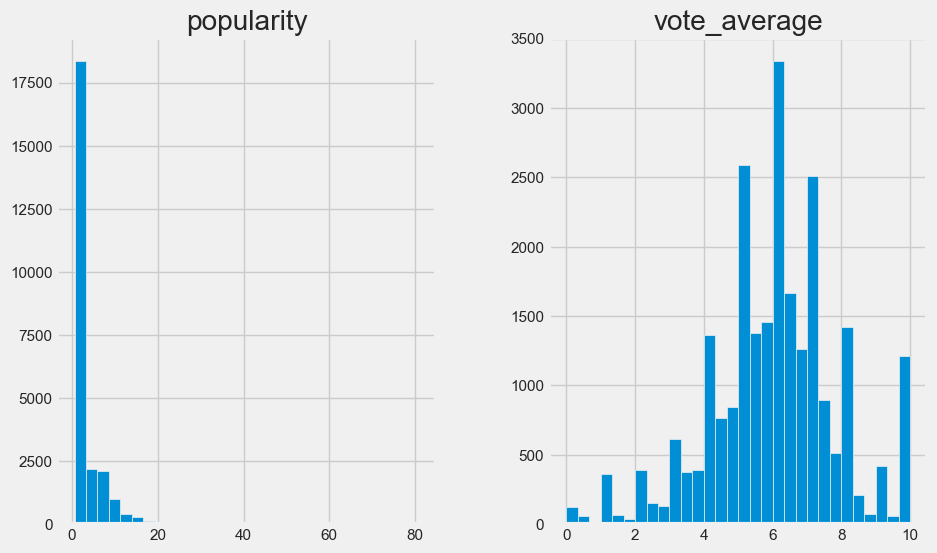

In [45]:
# Checking for Outliers
# Histograms for each feature
moviedb[['popularity', 'vote_average']].hist(bins=30, figsize=(10, 6))
plt.show()

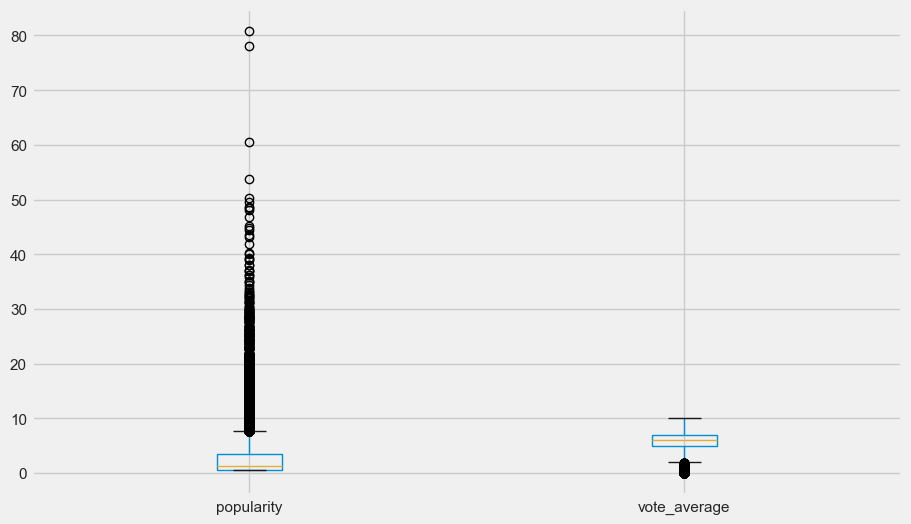

In [46]:
# Create box plots
moviedb[['popularity', 'vote_average', ]].boxplot(figsize=(10, 6))
plt.show()

In [47]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = moviedb[['popularity', 'vote_average' ]].quantile(0.25)
Q3 = moviedb[['popularity', 'vote_average' ]].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = ((moviedb[['popularity', 'vote_average']] < (Q1 - 1.5 * IQR)) | (moviedb[['popularity', 'vote_average']] > (Q3 + 1.5 * IQR)))

print("Outliers detected using IQR method:")
print(outliers.sum())

Outliers detected using IQR method:
popularity      2700
vote_average     649
dtype: int64


In [48]:
# Remove outliers
moviedb_no_outliers = moviedb[~((moviedb[['popularity', 'vote_average']] < (Q1 - 1.5 * IQR)) | 
                                           (moviedb[['popularity', 'vote_average']] > (Q3 + 1.5 * IQR))).any(axis=1)]

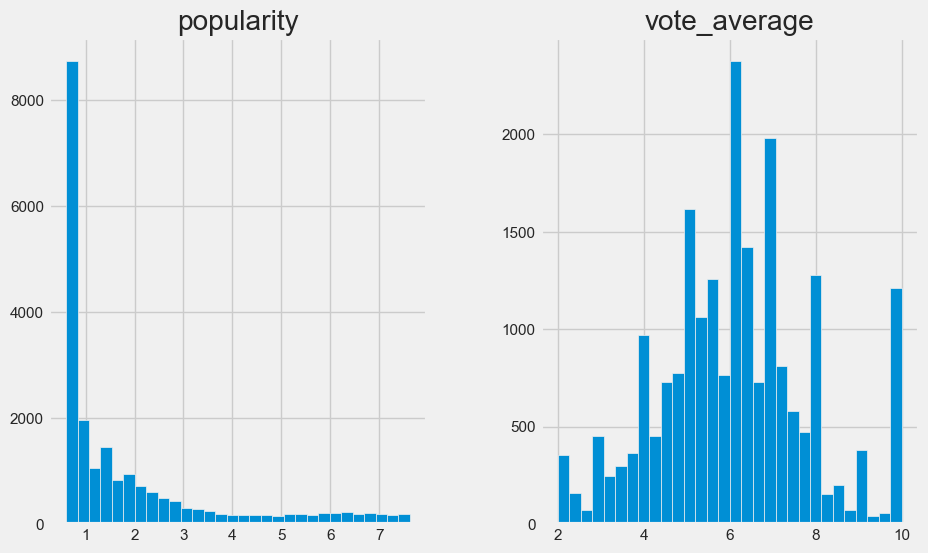

In [49]:
# Histograms for each feature
moviedb_no_outliers[['popularity', 'vote_average']].hist(bins=30, figsize=(10, 6))
plt.show()

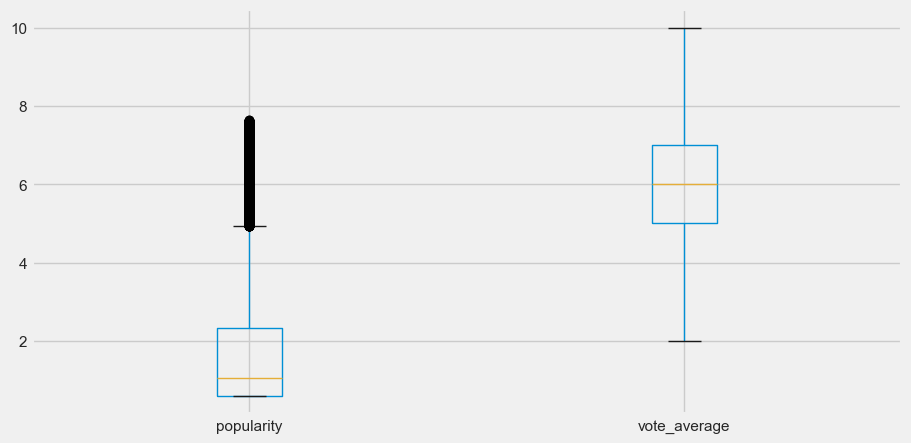

In [50]:
# Create box plots
moviedb_no_outliers[['popularity', 'vote_average']].boxplot(figsize=(10, 5))
plt.show()

In [51]:
moviedb['release_date'] = pd.to_datetime(moviedb['release_date'])
moviedb['genre_ids'] = moviedb['genre_ids'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

In [52]:
moviedb.head()

,genre_ids,id,popularity,release_date,title,vote_average
0,"[[12, 14, 10751]]",12444,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7
1,"[[14, 12, 16, 10751]]",10191,28.734,2010-03-26,How to Train Your Dragon,7.7
2,"[[12, 28, 878]]",10138,28.515,2010-05-07,Iron Man 2,6.8
3,"[[16, 35, 10751]]",862,28.005,1995-11-22,Toy Story,7.9
4,"[[28, 878, 12]]",27205,27.920,2010-07-16,Inception,8.3


In [53]:
moviedb.shape

(24688, 6)

## 4. Cleaning The Box Office Mojo Dataset

In [54]:
# General size of the dataset
bom.shape

(3387, 5)

In [55]:
#General overview of the dataset
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [56]:
#Filtering unnecessary Columns
bom.drop(['studio', 'year'], axis = 1 , inplace = True)

In [57]:
# Check for missing values
print(bom.isnull().sum())

title                0
domestic_gross      28
foreign_gross     1350
dtype: int64


In [58]:
# Handling missing values
bom = bom.dropna()

In [59]:
# Changing of 'Domestic_gross' data type to 'int'
bom['domestic_gross'] = bom['domestic_gross'].astype('int')


In [60]:
#Changing of 'Foreign_gross' Data type to 'int'
bom['foreign_gross'] = bom['foreign_gross'].astype(str)
bom['foreign_gross'] = bom['foreign_gross'].str.replace('[\$,]', '', regex=True).astype(float)
bom['foreign_gross'] = bom['foreign_gross'].round(0).astype(int)

In [61]:
# Creating a new column Total Gross
bom['total_gross'] = bom['foreign_gross'] + bom['domestic_gross']

In [62]:
# Statistical summary
bom.describe()

,domestic_gross,foreign_gross,total_gross
count,2.009000e+03,2.009000e+03,2.009000e+03
mean,4.697311e+07,7.571822e+07,1.226913e+08
std,8.159966e+07,1.381296e+08,2.074870e+08
min,4.000000e+02,6.000000e+02,4.900000e+03
25%,6.650000e+05,3.900000e+06,8.141000e+06
50%,1.650000e+07,1.930000e+07,4.230000e+07
75%,5.600000e+07,7.590000e+07,1.337000e+08
max,9.367000e+08,9.605000e+08,1.518900e+09


In [63]:
bom.head()

,title,domestic_gross,foreign_gross,total_gross
0,Toy Story 3,415000000,652000000,1067000000
1,Alice in Wonderland (2010),334200000,691300000,1025500000
2,Harry Potter and the Deathly Hallows Part 1,296000000,664300000,960300000
3,Inception,292600000,535700000,828300000
4,Shrek Forever After,238700000,513900000,752600000


### 5. IMDB Data - merging basics and ratings

In [64]:
imdb = pd.merge(movie_basics, movie_ratings, on='movie_id', how='left')
imdb

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0
...,...,...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama,NaN,NaN
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary,NaN,NaN
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy,NaN,NaN
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None,NaN,NaN


In [65]:
#filtering unnecessary columns
imdb.drop(['movie_id','original_title','start_year','numvotes'], axis =1 , inplace = True)

In [66]:
# Checking missing values
imdb.isna().sum()

primary_title          0
runtime_minutes    31739
genres              5408
averagerating      72288
dtype: int64

In [67]:
# Handling missing values
# replace missing values in 'genres' with 'unkown'
imdb['genres'].fillna('Unknown', inplace=True)

In [68]:
imdb = imdb.dropna()

In [69]:
# General Overview of Dataset
imdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66236 entries, 0 to 146134
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    66236 non-null  object 
 1   runtime_minutes  66236 non-null  float64
 2   genres           66236 non-null  object 
 3   averagerating    66236 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.5+ MB


In [70]:
#Checking for duplicates
imdb.duplicated(subset = ['primary_title']).value_counts()

False    62924
True      3312
Name: count, dtype: int64

In [71]:
# Use keep=False to keep all duplicates and sort_values to put duplicates next to each other
x = imdb[imdb.duplicated(keep=False)].sort_values(by='primary_title')
x

,primary_title,runtime_minutes,genres,averagerating
2632,Raggarjävlar (Swedish Greasers),70.0,Documentary,6.9
2658,Raggarjävlar (Swedish Greasers),70.0,Documentary,6.9


In [72]:
imdb = imdb.drop_duplicates(x)
imdb

,primary_title,runtime_minutes,genres,averagerating
0,Sunghursh,175.0,"Action,Crime,Drama",7.0
1,One Day Before the Rainy Season,114.0,"Biography,Drama",7.2
2,The Other Side of the Wind,122.0,Drama,6.9
4,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy",6.5
7,Joe Finds Grace,83.0,"Adventure,Animation,Comedy",8.1
...,...,...,...,...
146113,Padmavyuhathile Abhimanyu,130.0,Drama,8.4
146114,Swarm Season,86.0,Documentary,6.2
146115,Diabolik sono io,75.0,Documentary,6.2
146122,Sokagin Çocuklari,98.0,"Drama,Family",8.7


In [73]:
imdb.head()

,primary_title,runtime_minutes,genres,averagerating
0,Sunghursh,175.0,"Action,Crime,Drama",7.0
1,One Day Before the Rainy Season,114.0,"Biography,Drama",7.2
2,The Other Side of the Wind,122.0,Drama,6.9
4,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy",6.5
7,Joe Finds Grace,83.0,"Adventure,Animation,Comedy",8.1


# Data Merging

- We shall use **The Numbers** and **IMDB** dataset to get insights on our analysis, since they have columns that shall aid in answering our business problem

In [74]:
# Merging of IMDB and Numbers dataset using a common key
merged = pd.merge(numbers, imdb, left_on='movie', right_on='primary_title', how='inner')
merged.shape

(2645, 10)

In [75]:
# Assuming 'merged' is your merged DataFrame

# Split the 'genres' column
split_genres = merged['genres'].str.split(',', expand=True)

# Rename the new columns
split_genres.columns = [f'genre_{i+1}' for i in range(split_genres.shape[1])]

# Drop the original 'genres' column and join the new genre columns
merged = merged.drop(columns='genres').join(split_genres)

# Save the modified dataset to a CSV file in the current directory
merged.to_csv('merged_dataset_with_genres.csv', index=False)

print("Merged dataset with split genres saved successfully to 'merged_dataset_with_genres.csv'")


Merged dataset with split genres saved successfully to 'merged_dataset_with_genres.csv'


In [76]:
merged.columns


Index(['movie', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'total_gross', 'ROI', 'primary_title', 'runtime_minutes',
       'averagerating', 'genre_1', 'genre_2', 'genre_3'],
      dtype='object')

In [77]:
# Filtering unnecessary columns
merged.drop(['movie'],axis = 1, inplace =True)

In [78]:
merged.head()

,production_budget,domestic_gross,worldwide_gross,total_gross,ROI,primary_title,runtime_minutes,averagerating,genre_1,genre_2,genre_3
0,425000000.0,760507625.0,2.776345e+09,3.536853e+09,7.322007,Avatar,93.0,6.1,Horror,None,None
1,410600000.0,241063875.0,1.045664e+09,1.286728e+09,2.133774,Pirates of the Caribbean: On Stranger Tides,136.0,6.6,Action,Adventure,Fantasy
2,350000000.0,42762350.0,1.497624e+08,1.925247e+08,-0.449929,Dark Phoenix,113.0,6.0,Action,Adventure,Sci-Fi
3,330600000.0,459005868.0,1.403014e+09,1.862020e+09,4.632244,Avengers: Age of Ultron,141.0,7.3,Action,Adventure,Sci-Fi
4,300000000.0,678815482.0,2.048134e+09,2.726950e+09,8.089832,Avengers: Infinity War,149.0,8.5,Action,Adventure,Sci-Fi


In [79]:
import os

In [80]:

# List files in the current directory to verify the CSV file is saved
import os
for file in os.listdir('.'):
    print(file)

.git
.gitattributes
.gitignore
.ipynb_checkpoints
LICENSE
merged_dataset_with_genres.csv
Movies.ipynb
README.md
Zipped file


# Exploratory  Data Analysis

## Univariate Analysis

### 1. Distribution of Average_Rating

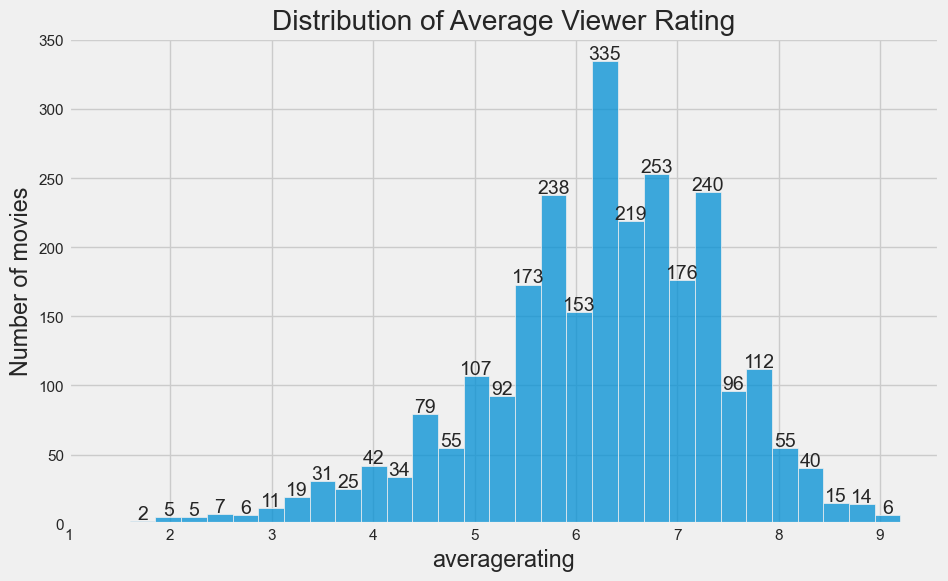

In [81]:
# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.histplot(merged['averagerating'], bins=30)

# Add the title
plt.title('Distribution of Average Viewer Rating')
plt.ylabel('Number of movies')

# Add counts on top of each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(f'{int(height)}', 
                (patch.get_x() + patch.get_width() / 2., height),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Customize x-axis ticks
plt.xticks(ticks=[i for i in range(int(merged['averagerating'].min()), int(merged['averagerating'].max()) + 1)])

# Show the plot
plt.show()

In [82]:
# Filter movies with rating 9 and above
high_rated_movies = merged[merged['averagerating'] >= 9]

In [83]:
print("Number of high-rated movies:", len(high_rated_movies))

Number of high-rated movies: 6


In [84]:
# Sort high-rated movies by average rating in descending order
high_rated_movies_sorted = high_rated_movies.sort_values(by='averagerating',ascending =False)
high_rated_movies


,production_budget,domestic_gross,worldwide_gross,total_gross,ROI,primary_title,runtime_minutes,averagerating,genre_1,genre_2,genre_3
479,60000000.0,30063805.0,30063805.0,60127610.0,0.002127,Dragonfly,75.0,9.0,Action,Adventure,Sci-Fi
595,48000000.0,124107476.0,208300000.0,332407476.0,5.925156,Traffic,110.0,9.2,Documentary,None,None
627,45000000.0,22006296.0,112006296.0,134012592.0,1.978058,Frankenstein,130.0,9.0,Drama,None,None
1261,20000000.0,0.0,1703281.0,1703281.0,-0.914836,Survivor,81.0,9.0,Biography,Crime,Documentary
1724,9500000.0,3573673.0,5278632.0,8852305.0,-0.068178,The Runaways,108.0,9.2,Adventure,None,None
2148,3000000.0,1803064.0,4495262.0,6298326.0,1.099442,The Wall,78.0,9.2,Documentary,None,None


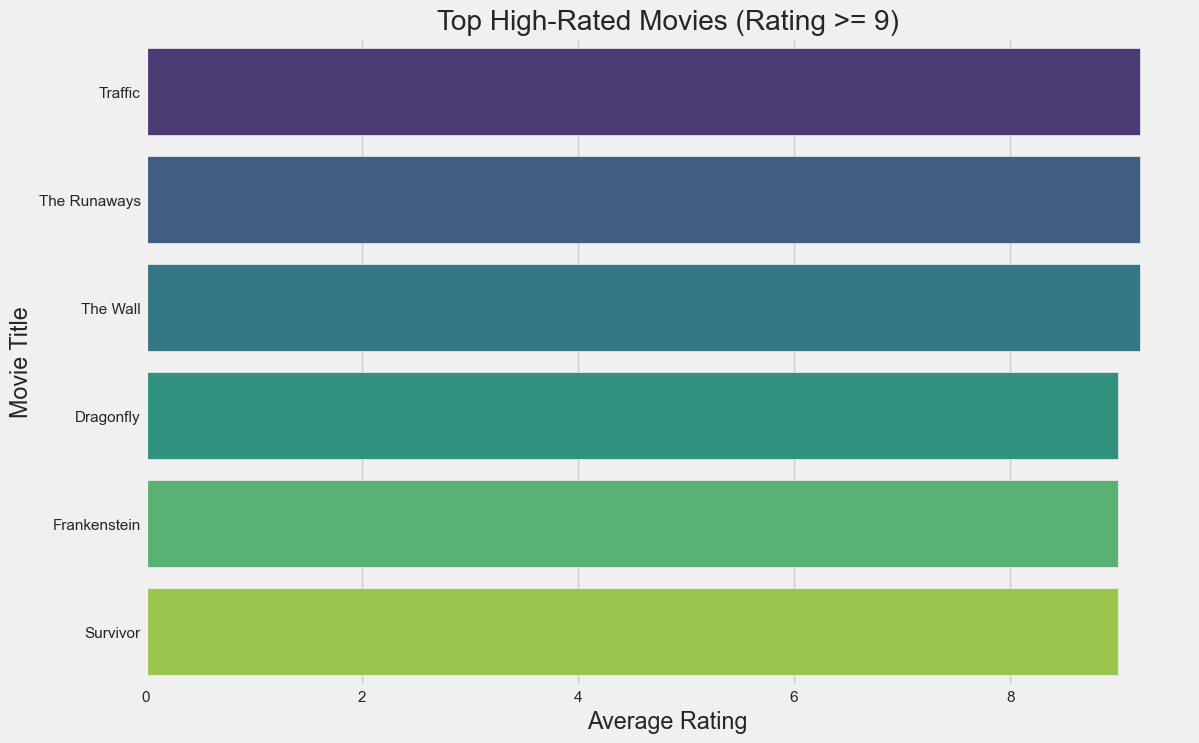

In [85]:
# Create a bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='averagerating', y='primary_title', data=high_rated_movies_sorted, palette='viridis')

# Add title and labels
plt.title('Top High-Rated Movies (Rating >= 9)')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')


# Show the plot
plt.show()

From the statistical summary, we observe the following:

- **Most Common Rating**: Approximately 6.2
- **Highly Rated Movies (Rating ≥ 9)**: Very few movies, making up a small percentage of the dataset.

### Insights

- **Typical Ratings**: The majority of movies have ratings clustered around 6.2, representing **approximately 50%** of the movies being rated **between 6.4 and 7.1**.
- **Highly Rated Movies**: Movies with **ratings of 9 or above are rare**, constituting about **1%** of the dataset. This indicates a small percentage of movies achieve exceptional ratings.

### Detailed Percentages

- **Movies Rated Below 6**: **Approximately 25%** of movies fall below the 25th percentile rating of 5.6.
- **Movies Rated Above 7.1**: **About 25%** of movies have ratings above the 75th percentile of 7.1.
- **Movies with Maximum Rating**: Only a small fraction of movies, **roughly 1% (or fewer)**, have ratings close to the maximum value of 9.2.


## 2. Distribution of Movie Runtime in Minutes

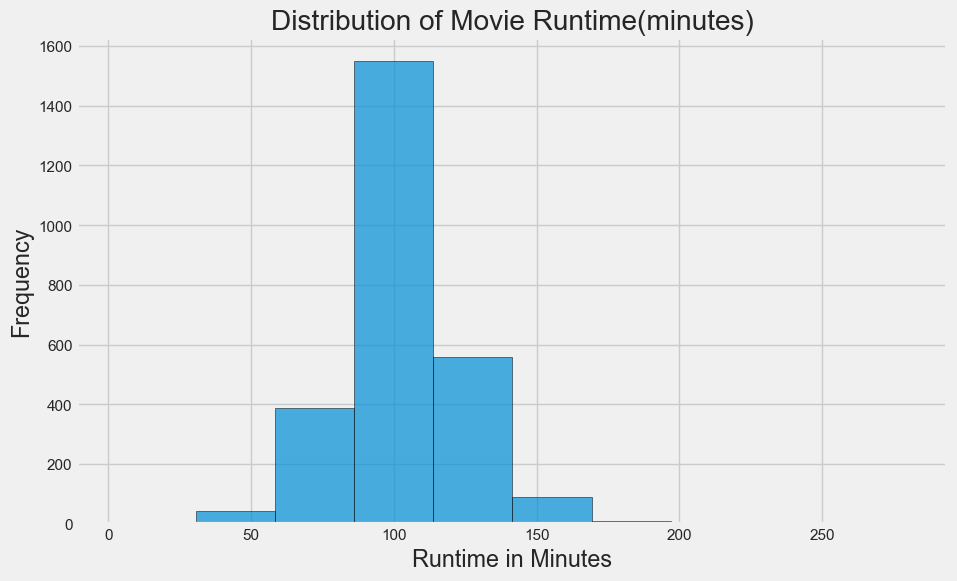

In [86]:
# Plot histogram for Runtime
plt.figure(figsize=(10, 6))
plt.hist(merged['runtime_minutes'], bins=10, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Runtime in Minutes')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Runtime(minutes)')

# Show plot
plt.grid(True)
plt.show()

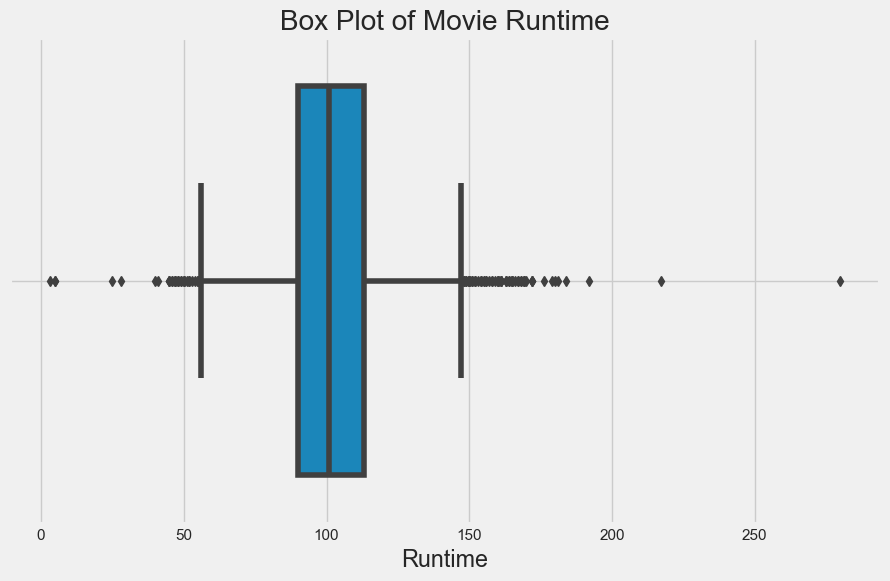

In [87]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged['runtime_minutes'])
plt.xlabel('Runtime')
plt.title('Box Plot of Movie Runtime')
plt.grid(True)
plt.show()


### Runtime Distribution Summary

From the statistical summary, we observe the following:

- **Most Common Runtime**: Approximately **101 minutes**, which is close to the median value.
- **Extremely Long Movies**: A small number of movies have runtimes exceeding 2 hours, with some going up to 280 minutes.

### Insights

- **Typical Runtimes**: The majority of movies have runtimes clustered around the median of 101 minutes, with **approximately 50%** of movies having **runtimes between 90 and 113 minutes.**
- **Extreme Values**: Movies with runtimes approaching the maximum value of 280 minutes are rare, constituting a small percentage of the dataset.

### Detailed Percentages

- **Movies with Runtime Below 90 Minutes**  :   **Approximately 25%** of movies have **runtimes shorter than** the 25th percentile value of **90 minutes**.
- **Movies with Runtime Above 113 Minutes**  :  **About 25%** of movies have **runtimes longer than** the 75th percentile value of **113 minutes.**
- **Movies with Maximum Runtime**  :            Only a very small fraction of movies, **less than 1%**, have runtimes close to the maximum value of **280 minutes.**


## 3. Distribution of Return On Investment(ROI)

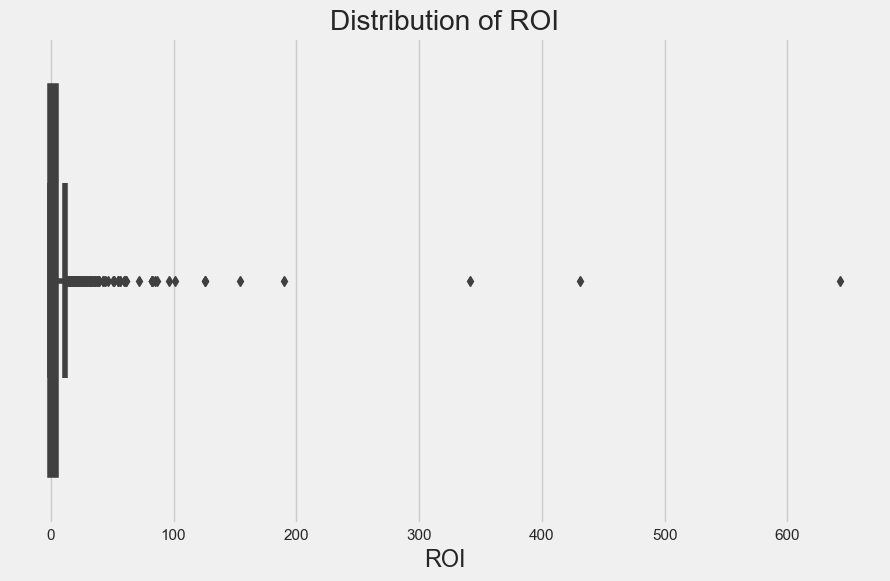

In [88]:
plt.figure(figsize=(10, 6))
sns.boxplot(x = merged['ROI'])
plt.title('Distribution of ROI')
plt.show()

In [89]:
merged_ROI = merged['ROI']
merged_ROI.describe()

count    2645.000000
mean        4.402186
std        19.231866
min        -1.000000
25%        -0.519315
50%         1.436577
75%         4.412967
max       643.208840
Name: ROI, dtype: float64

### Observation 
- ROI'S above 12 seem to be categorized ass outliers from our boxplot since ,In a business  setting a good ROI ranges at 5 and exceptional performance is considered to be at 10 to 20 hence deciding on removing the outliers.

In [90]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = merged[['ROI']].quantile(0.25)
Q3 = merged[['ROI']].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = ((merged[['ROI']] < (Q1 - 1.5 * IQR)) | (merged[[ 'ROI']] > (Q3 + 1.5 * IQR)))

print("Outliers detected using IQR method:")
print(outliers.sum())

Outliers detected using IQR method:
ROI    197
dtype: int64


In [91]:
# Remove outliers
mergedROI_no_outliers = merged[~((merged[['ROI']] < (Q1 - 1.5 * IQR)) | 
                                           (merged[['ROI']] > (Q3 + 1.5 * IQR))).any(axis=1)]

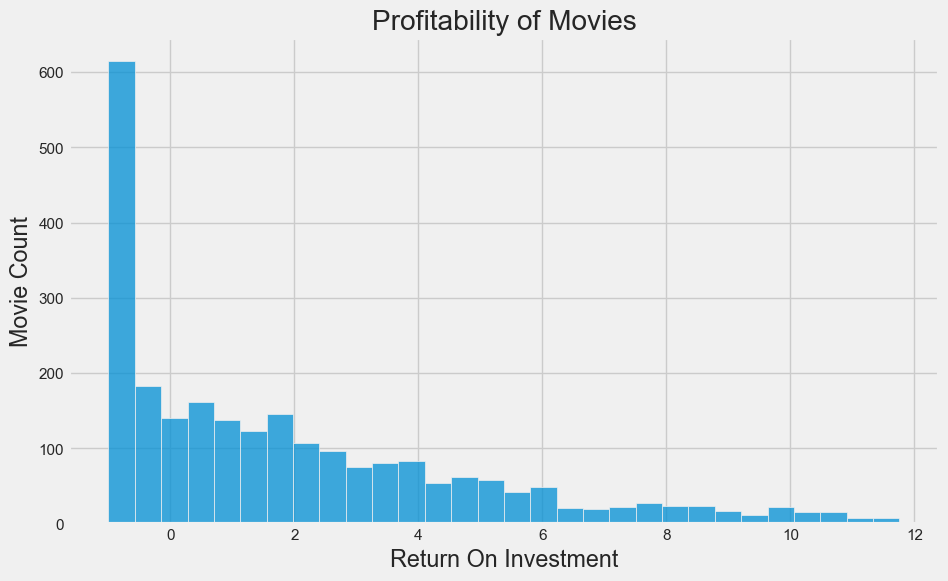

In [92]:
plt.figure(figsize=(10, 6))
sns.histplot(mergedROI_no_outliers['ROI'], bins=30)
plt.title('Profitability of Movies')
plt.ylabel('Movie Count')
plt.xlabel('Return On Investment')
plt.show()


In [93]:
mergedROI_no_outliers['ROI'].describe()

count    2448.000000
mean        1.916405
std         2.960622
min        -1.000000
25%        -0.580626
50%         1.092370
75%         3.523029
max        11.756904
Name: ROI, dtype: float64

In [94]:
# Filter movies with based on profitability
profit = mergedROI_no_outliers[mergedROI_no_outliers['ROI'] > 0]
break_even = mergedROI_no_outliers[mergedROI_no_outliers['ROI'] == 0]
loss = mergedROI_no_outliers[mergedROI_no_outliers['ROI'] < 0]




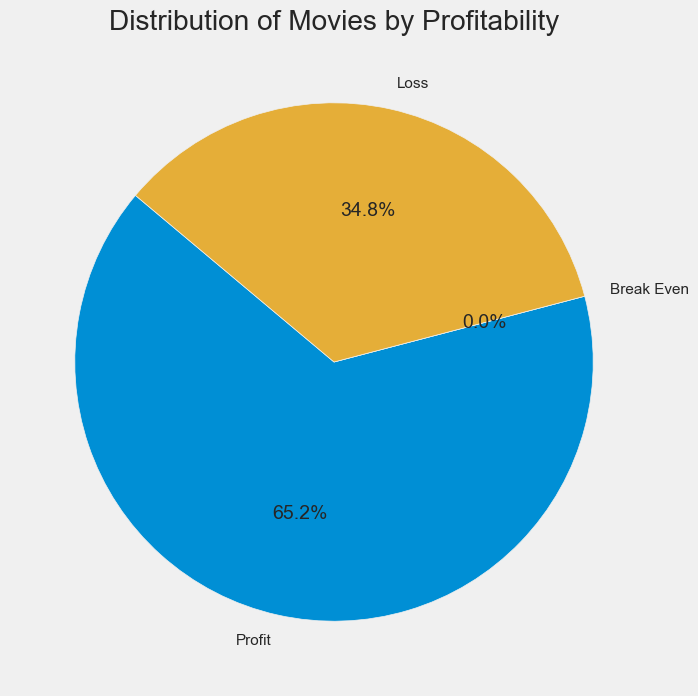

In [95]:
import matplotlib.pyplot as plt

# Calculate the counts for each category
counts = [len(profit), len(break_even), len(loss)]
labels = ['Profit', 'Break Even', 'Loss']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Movies by Profitability')
plt.show()


In [96]:
# Sort ROI by PROFITABILITY
profitable = mergedROI_no_outliers.sort_values(by='ROI',ascending =False)
top_profitable = profitable.head(5)
top_profitable

,production_budget,domestic_gross,worldwide_gross,total_gross,ROI,primary_title,runtime_minutes,averagerating,genre_1,genre_2,genre_3
1615,10000000.0,48958273.0,78610769.0,127569042.0,11.756904,Lady Bird,94.0,7.4,Comedy,Drama,None
1544,12000000.0,70012847.0,82497035.0,152509882.0,11.709157,Act of Valor,110.0,6.5,Action,Adventure,Drama
1955,5000000.0,21222315.0,41824066.0,63046381.0,11.609276,"As Above, So Below",93.0,6.2,Adventure,Horror,Mystery
1272,19000000.0,97670358.0,141344255.0,239014613.0,11.579716,Sausage Party,89.0,6.2,Adventure,Animation,Comedy
1391,15000000.0,93589701.0,93589701.0,187179402.0,11.478627,The Color Purple,97.0,6.6,Action,Drama,None


In [97]:
# Sort ROI by LOSS
Loss = mergedROI_no_outliers.sort_values(by='ROI',ascending =False)
Top_Losers = Loss.tail(5)


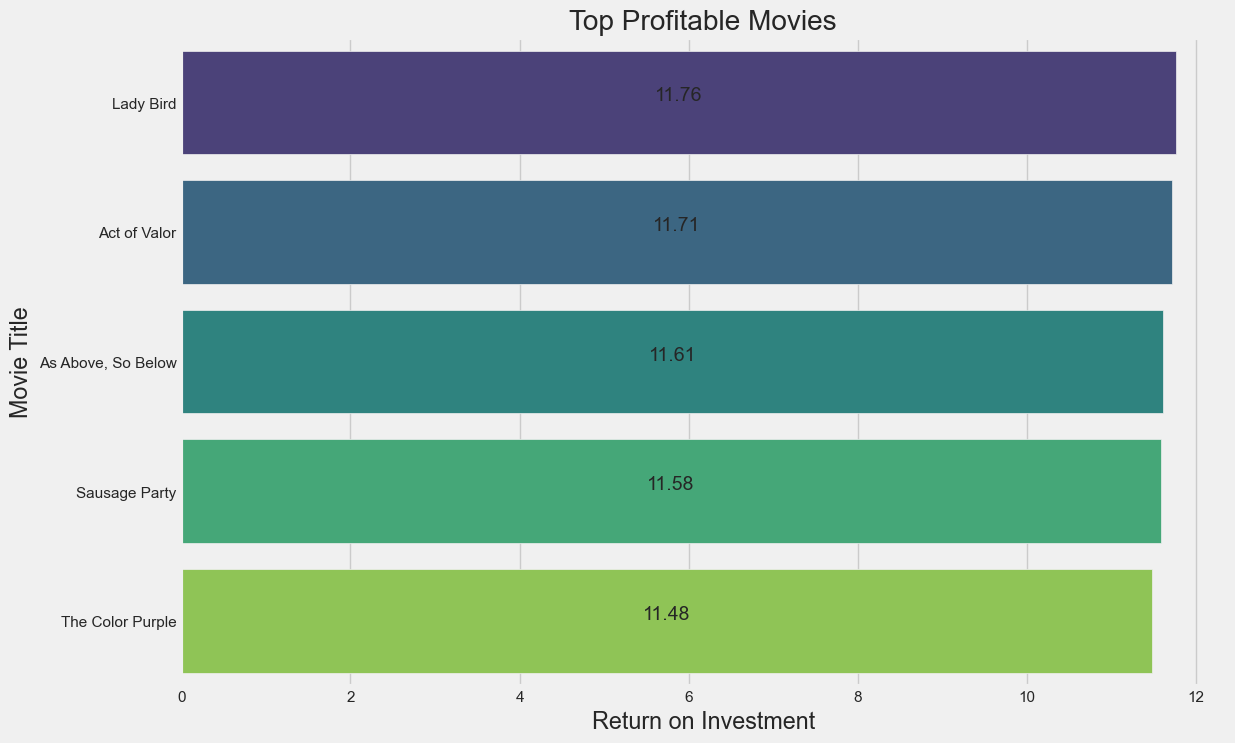

In [98]:
# Create a bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='ROI', y='primary_title', data=top_profitable, palette='viridis')

# Add title and labels
plt.title('Top Profitable Movies')
plt.xlabel('Return on Investment')
plt.ylabel('Movie Title')

# Add counts on top of each bar
for patch in ax.patches:
    width = patch.get_width()
    ax.annotate(f'{width:.2f}', 
                (patch.get_x() + width / 2., patch.get_y() + patch.get_height() / 2.),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Show Plot
plt.show()

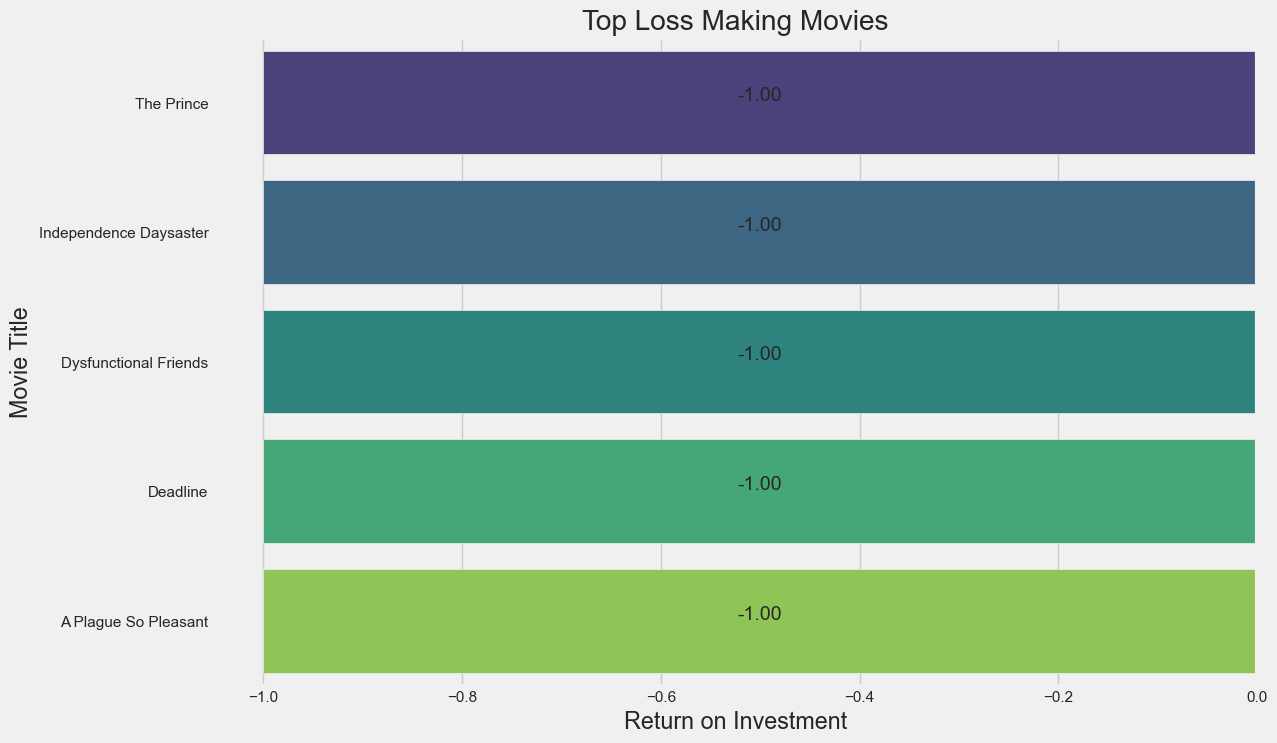

In [99]:
# Create a bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='ROI', y='primary_title', data=Top_Losers, palette='viridis')

# Add title and labels
plt.title('Top Loss Making Movies')
plt.xlabel('Return on Investment')
plt.ylabel('Movie Title')

# Add counts on top of each bar
for patch in ax.patches:
    width = patch.get_width()
    ax.annotate(f'{width:.2f}', 
                (patch.get_x() + width / 2., patch.get_y() + patch.get_height() / 2.),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Show Plot
plt.show()

## Statistical Summary of Return on Investment (ROI) for Films

From the statistical summary, we observe the following  :

### Most Common ROI
- **Approximately 1.09**, which is close to the median value.

### Extremely High ROI
- A small number of films have ROIs exceeding 3.52, with some going up to **11.76**.

### Insights
- **Typical ROIs**: The majority of films have ROIs clustered around the median of 1.09, with **approximately 50%** of films having ROIs between **-0.58 and 3.52**.
- **Extreme Values**: Films with ROIs approaching the maximum value of 11.76 are rare, constituting a small percentage of the dataset.

### Detailed Percentages
- **Films with ROI Below -0.58**: Approximately 25% of films have ROIs lower than the 25th percentile value of **-0.58**.
- **Films with ROI Above 3.52**: About 25% of films have ROIs higher than the 75th percentile value of **3.52**.
- **Films with Maximum ROI**: Only a very small fraction of films, less than **1%**, have ROIs close to the maximum value of **11.76**.

### Pie Chart of Film Profitability

Based on the analysis, the distribution of film profitability is as follows:

- **65.2% of films made a profit**
- **34.8% of films made a loss**

## 4.Distribution of Movies by the Primary Genre(Genre_1)

In [100]:
Primary_genre = merged['genre_1']
Unique_Genres = Primary_genre.unique()
Count = Primary_genre.value_counts()

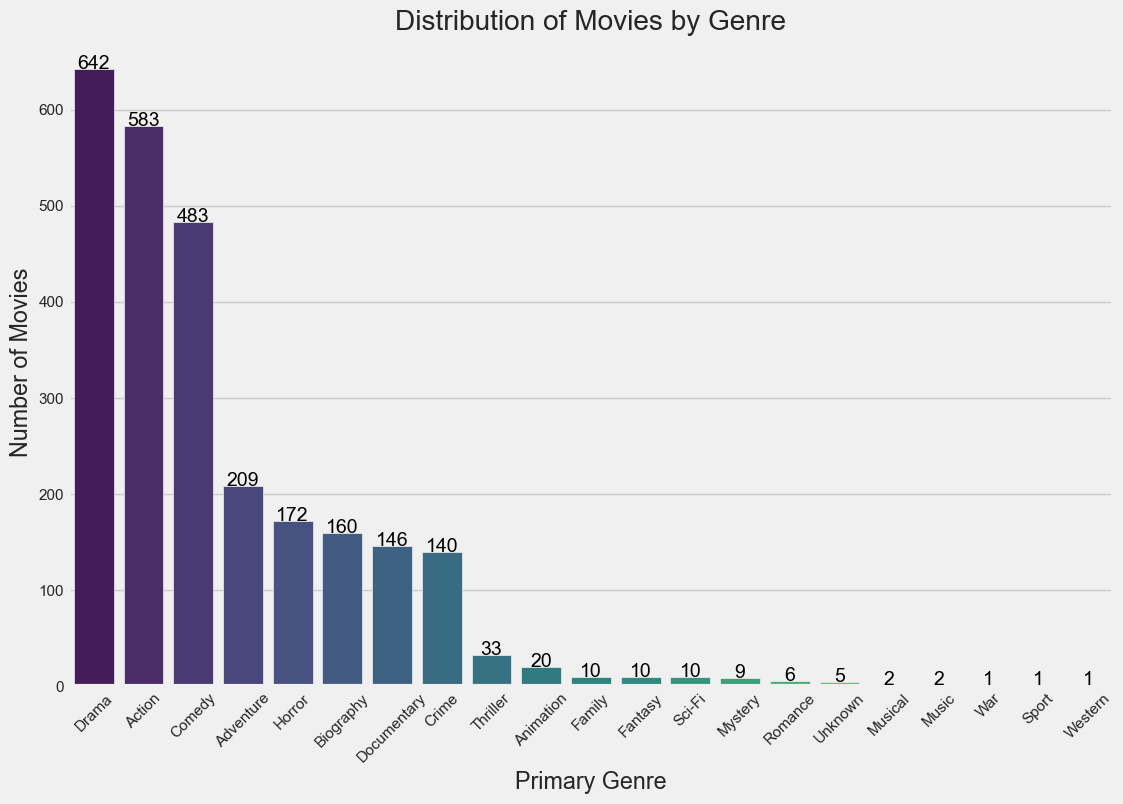

In [101]:
# Create DataFrame
df = pd.DataFrame({'Genre': Count.index, 'Count': Count.values})

# Plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Genre', y='Count', data=df, palette='viridis')
plt.title('Distribution of Movies by Genre')
plt.xlabel('Primary Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)

# Add counts on top of each bar
for index, row in df.iterrows():
    barplot.text(index, row.Count, round(row.Count, 2), color='black', ha="center")

plt.show()

## Statistical Summary of Movie Genres

From the dataset, we observe the following distribution of primary genres:

### Top Genres by Movie count

- **Drama**: 642 movies (26.2%)
- **Action**: 583 movies (23.8%)
- **Comedy**: 483 movies (19.7%)
- **Adventure**: 209 movies (8.5%)
- **Horror**: 172 movies (7.0%)
- **Biography**: 160 movies (6.5%)
- **Documentary**: 146 movies (6.0%)
- **Crime**: 140 movies (5.7%)

### Insights

- **Drama** is the most common genre, making up 26.2% of the dataset.
- **Action** and **Comedy** are also prevalent, comprising 23.8% and 19.7% of the dataset, respectively.
- The top 8 genres account for the majority of the movies, with **Drama**, **Action**, and **Comedy** alone making up nearly 70% of the dataset.

## 5. Distribution Of Films by Production Budgets

In [102]:
merged['production_budget'].describe()

count    2.645000e+03
mean     3.544543e+07
std      4.880154e+07
min      1.400000e+03
25%      5.000000e+06
50%      1.800000e+07
75%      4.200000e+07
max      4.250000e+08
Name: production_budget, dtype: float64

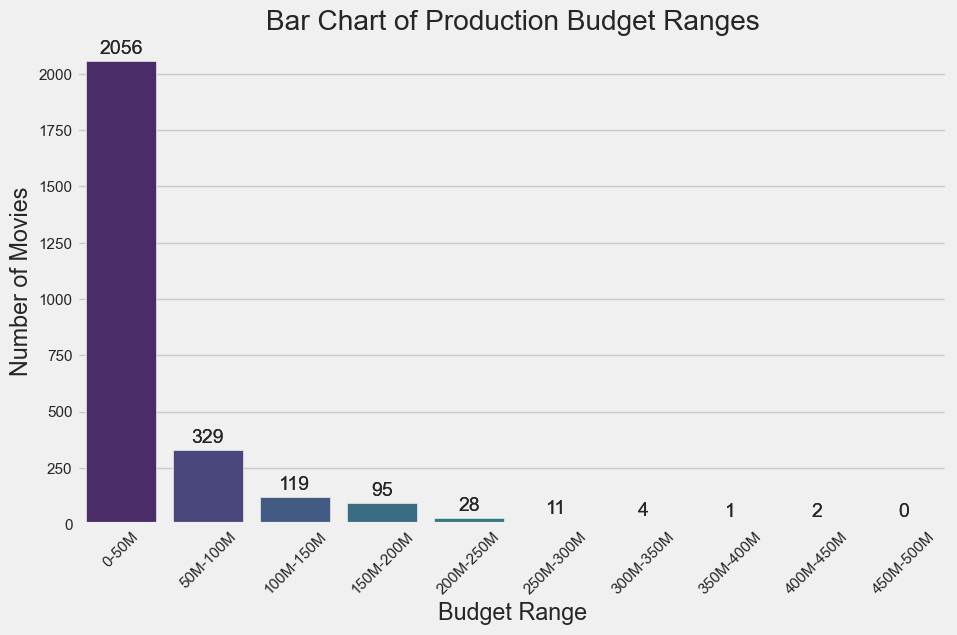

In [103]:
# Define budget bins and labels
bins = [0, 50000000, 100000000,150000000, 200000000, 250000000, 300000000,350000000, 400000000,450000000, 500000000]
labels = ['0-50M','50M-100M', '100M-150M','150M-200M', '200M-250M','250M-300M', '300M-350M','350M-400M', '400M-450M','450M-500M']

# Create a new column with binned budget categories
merged['budget_bin'] = pd.cut(merged['production_budget'], bins=bins, labels=labels, right=False)

# Plotting the bar chart for binned budgets
plt.figure(figsize=(10, 6))
barplot = sns.countplot(x='budget_bin', data=merged, palette='viridis')
sns.countplot(x='budget_bin', data=merged, palette='viridis')
plt.title('Bar Chart of Production Budget Ranges')
plt.xlabel('Budget Range')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Add labels to the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')
    
plt.show()

In [104]:
# Highest production budgets
top_5 = merged.sort_values(by='production_budget', ascending=False).head(5)
top_5.head()

,production_budget,domestic_gross,worldwide_gross,total_gross,ROI,primary_title,runtime_minutes,averagerating,genre_1,genre_2,genre_3,budget_bin
0,425000000.0,760507625.0,2.776345e+09,3.536853e+09,7.322007,Avatar,93.0,6.1,Horror,None,None,400M-450M
1,410600000.0,241063875.0,1.045664e+09,1.286728e+09,2.133774,Pirates of the Caribbean: On Stranger Tides,136.0,6.6,Action,Adventure,Fantasy,400M-450M
2,350000000.0,42762350.0,1.497624e+08,1.925247e+08,-0.449929,Dark Phoenix,113.0,6.0,Action,Adventure,Sci-Fi,350M-400M
3,330600000.0,459005868.0,1.403014e+09,1.862020e+09,4.632244,Avengers: Age of Ultron,141.0,7.3,Action,Adventure,Sci-Fi,300M-350M
4,300000000.0,678815482.0,2.048134e+09,2.726950e+09,8.089832,Avengers: Infinity War,149.0,8.5,Action,Adventure,Sci-Fi,300M-350M


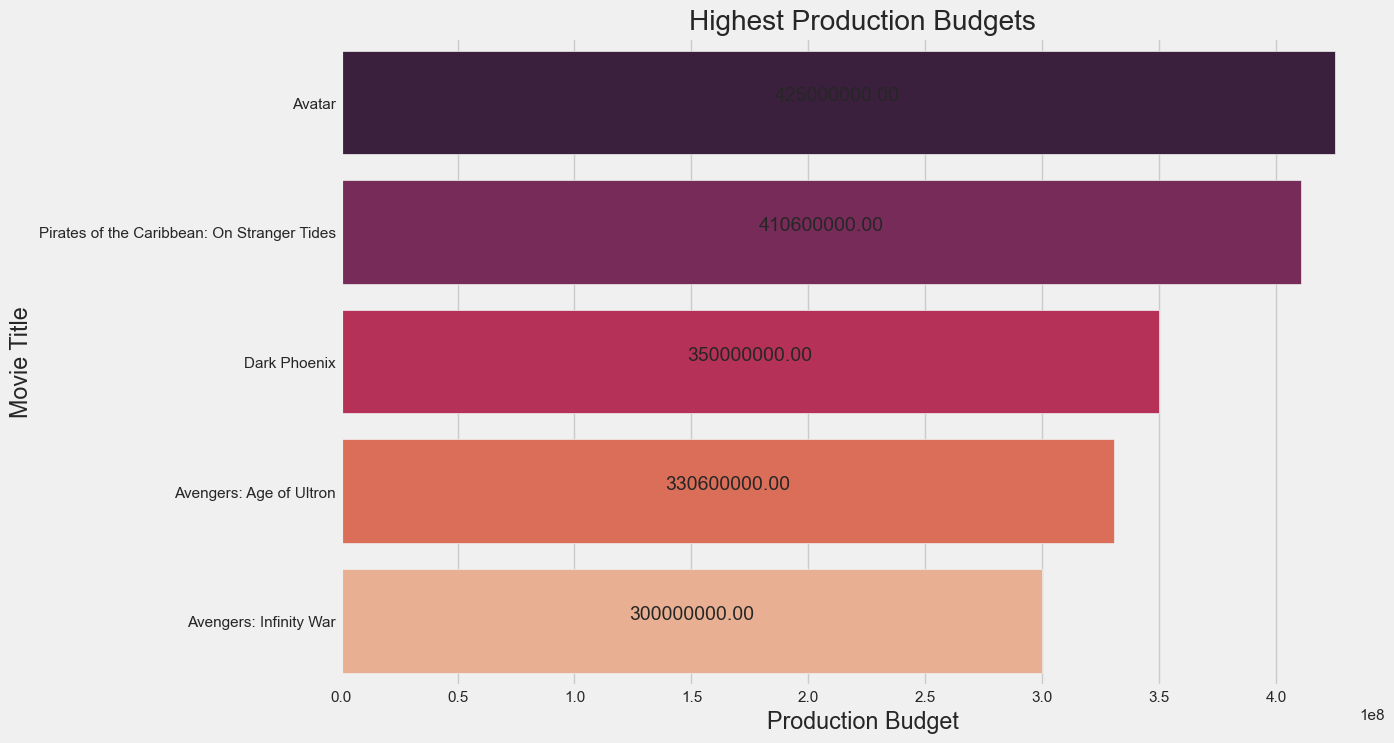

In [105]:
# Create a bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='production_budget', y='primary_title', data=top_5, palette='rocket')

# Add title and labels
plt.title('Highest Production Budgets')
plt.xlabel('Production Budget')
plt.ylabel('Movie Title')

# Add counts on top of each bar
for patch in ax.patches:
    width = patch.get_width()
    ax.annotate(f'{width:.2f}', 
                (patch.get_x() + width / 2., patch.get_y() + patch.get_height() / 2.),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Show Plot
plt.show()

In [106]:
#lowest production budget
bottom_5 = merged.sort_values(by='production_budget', ascending=True).head(5)
bottom_5.head()

,production_budget,domestic_gross,worldwide_gross,total_gross,ROI,primary_title,runtime_minutes,averagerating,genre_1,genre_2,genre_3,budget_bin
2644,1400.0,0.0,0.0,0.0,-1.000000,A Plague So Pleasant,76.0,5.4,Drama,Horror,Thriller,0-50M
2643,7000.0,0.0,0.0,0.0,-1.000000,Red 11,77.0,5.6,Horror,Sci-Fi,Thriller,0-50M
2642,9000.0,4584.0,4584.0,9168.0,0.018667,Newlyweds,95.0,6.4,Comedy,Drama,None,0-50M
2641,10000.0,94596.0,94596.0,189192.0,17.919200,Cure,93.0,4.9,Drama,None,None,0-50M
2640,15000.0,0.0,0.0,0.0,-1.000000,Stories of Our Lives,60.0,7.5,Drama,None,None,0-50M


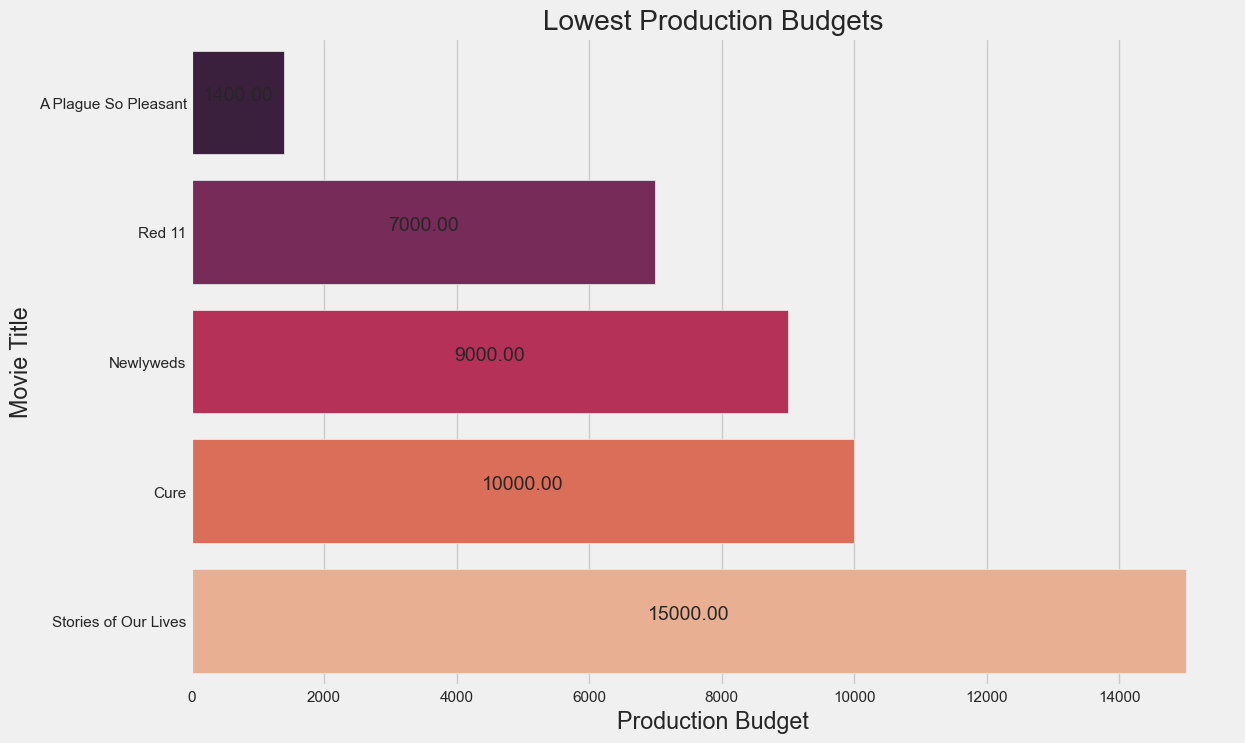

In [107]:
# Create a bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='production_budget', y='primary_title', data=bottom_5, palette='rocket')

# Add title and labels
plt.title('Lowest Production Budgets')
plt.xlabel('Production Budget')
plt.ylabel('Movie Title')

# Add counts on top of each bar
for patch in ax.patches:
    width = patch.get_width()
    ax.annotate(f'{width:.2f}', 
                (patch.get_x() + width / 2., patch.get_y() + patch.get_height() / 2.),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Show Plot
plt.show()

From the dataset we can see that:

**Most Common Budget Range**
 * 0 - 5O million dollars which the sample mean falls within

**Data Skewness**
 * The data skews heavily to the left.

**Highest Budget**
 * At 425m dollars, Avatar has the highest production budget, with the rest of the top 5 being within 125m dollars of it.
**Lowest Budget**
 * At 1400 dollars, A Plague so Pleasant has the lowest production budget with the rest of the bottom 5 being within 13,600 dollars of it.

### Insights
 * A large number of the films, around **78%** fall **below the mean value(42m dollars)**.
 * Only 2 films, **less than 1%**, have close to the **highest production budget of 425 million dollars**.

# Bivariate Analysis With Statistical Tests And Linear Regression Models

## 1.Analysis of Average Rating compared against Return on Invedstment (ROI)

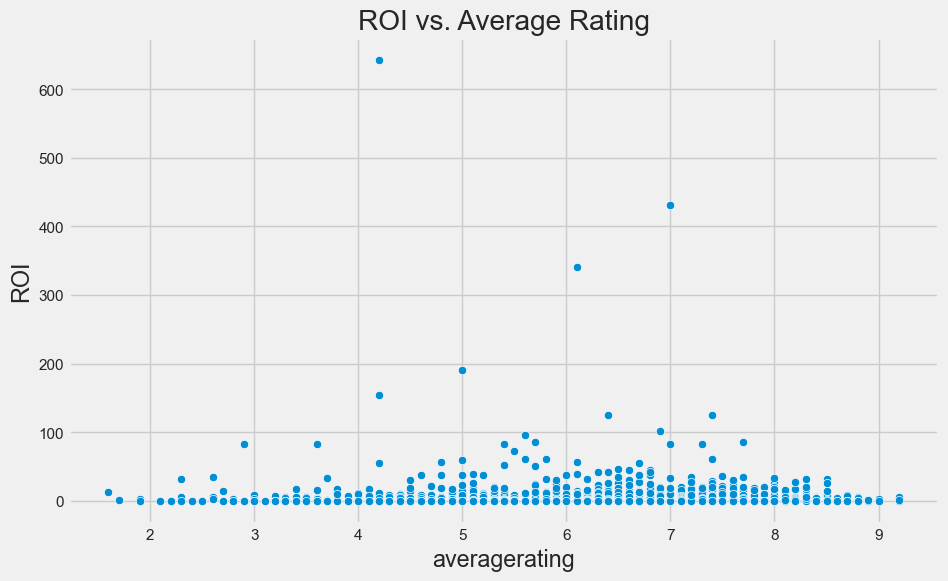

In [108]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='averagerating', y='ROI')
plt.title('ROI vs. Average Rating')
plt.show()

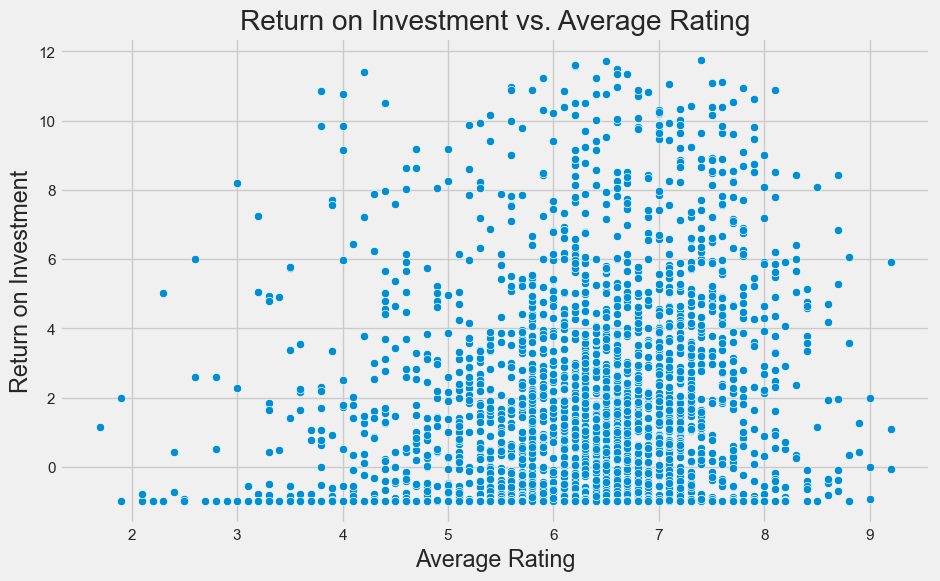

In [109]:
# Visualisation of the more filterd data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged['averagerating'], y=mergedROI_no_outliers['ROI'])
plt.title('Return on Investment vs. Average Rating')
plt.ylabel('Return on Investment')
plt.xlabel('Average Rating')

plt.show()

### . Determining whether high average rating indicates high ROI

In [110]:
correlation = merged['averagerating'].corr(mergedROI_no_outliers['ROI'])
print(f'Correlation between Vote Average and ROI: {correlation}')


Correlation between Vote Average and ROI: 0.2019403676524806


### .Fitting a linear regression model to see how well vote_average predicts ROI.

!pip install scikit-learn

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
X = merged[['averagerating']]
y = merged['ROI']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 73.76193724238965
R^2 Score: -0.008615367975004506


### .Statistical Testing

In [112]:
import statsmodels.api as sm

# Add a constant term for the intercept
X_train_const = sm.add_constant(X_train)

# Fit the regression model using statsmodels
model = sm.OLS(y_train, X_train_const).fit()

# Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.02692
Date:                Fri, 26 Jul 2024   Prob (F-statistic):              0.870
Time:                        21:07:21   Log-Likelihood:                -9451.2
No. Observations:                2116   AIC:                         1.891e+04
Df Residuals:                    2114   BIC:                         1.892e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.1687      2.465      1.691

## Key Findings
### 1 .Correlation Analysis:

- **Correlation Coefficient**: The **correlation coefficient** between vote average and ROI is **0.2019**.
- **Interpretation**: This indicates a **weak positive correlation**. While there is a slight tendency for movies with higher average ratings to have higher ROI, the relationship is not strong.
### 2. Linear Regression Model:

- **Mean Squared Error (MSE)**: The **MSE** of the model is **73.76**, indicating the average squared difference between the predicted and actual ROI values.
- **R^2 Score**: The **R^2 score** is **-0.0086**.
- **Interpretation**: The negative R^2 score suggests that the model does not explain the variance in ROI and performs worse than a horizontal line representing the mean ROI.
### 3.Regression Coefficients:
- **Intercept (const)**: 4.1687
- **Coefficient for vote average**: 0.0636
- **P-Value** for vote average: 0.870 (greater than 0.05)
- **Interpretation**: The high p-value indicates that the **vote average is not a statistically significant predictor of ROI**.
Statistical Testing:

### 4.F-statistic: 0.02692
- **Prob (F-statistic)**: 0.870
- **Interpretation**: The F-statistic and its corresponding p-value further **confirm that the vote average does not significantly explain the variation in ROI**.

## 2. Analysis of ROI against Runtime

### QUESTION : Which films are profitable? (Longer/Shorter)

In [113]:
# Categorize movies by runtime
def categorize_runtime(runtime):
    if runtime < 90:
        return 'Short_Movies'
    elif 90 <= runtime <= 113:
        return 'Medium_Movies'
    else:
        return 'Long_Movies'

merged['runtime_category'] = merged['runtime_minutes'].apply(categorize_runtime)


In [114]:
# Calculate average ROI for each runtime category
average_roi_by_runtime = merged.groupby('runtime_category')['ROI'].mean().reset_index()
print(average_roi_by_runtime)


  runtime_category       ROI
0      Long_Movies  4.595638
1    Medium_Movies  3.305430
2     Short_Movies  6.851074


In [115]:
data = {
    'runtime_category': ['Long_Movies', 'Medium_Movies', 'Short_Movies'],
    'ROI': [4.595638, 3.30543, 6.851074]
}

In [116]:
df = pd.DataFrame(data)

# Define runtime in minutes for each category
category_to_runtime = {
    'Short_Movies': 90,   
    'Medium_Movies': 113,
    'Long_Movies': 150
}

# Map categories to runtime in minutes
df['runtime_minutes'] = df['runtime_category'].map(category_to_runtime)

# Print DataFrame to verify
print(df)


  runtime_category       ROI  runtime_minutes
0      Long_Movies  4.595638              150
1    Medium_Movies  3.305430              113
2     Short_Movies  6.851074               90


In [117]:
# Extract ROIs by category
short_roi = df[df['runtime_category'] == 'Short_Movies']['ROI']
medium_roi = df[df['runtime_category'] == 'Medium_Movies']['ROI']
long_roi = df[df['runtime_category'] == 'Long_Movies']['ROI']


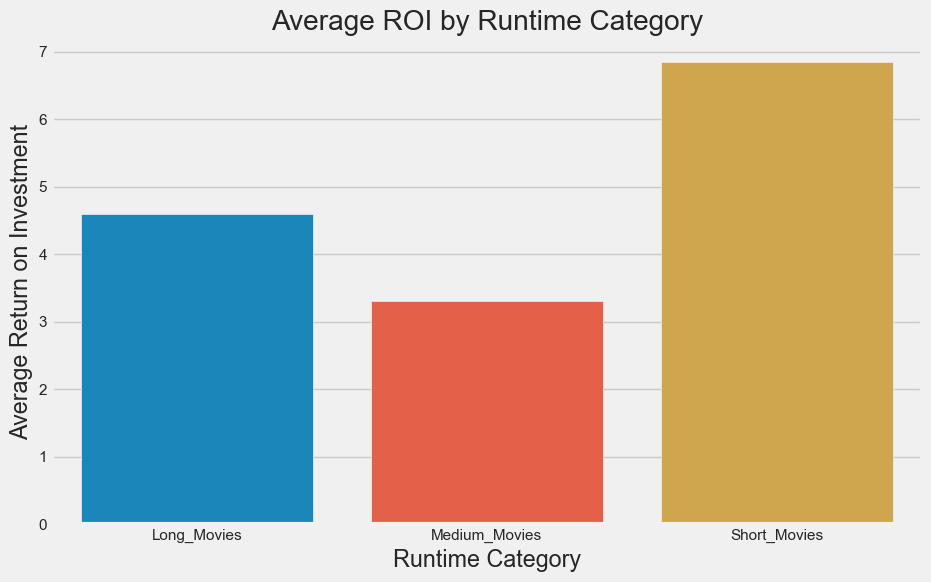

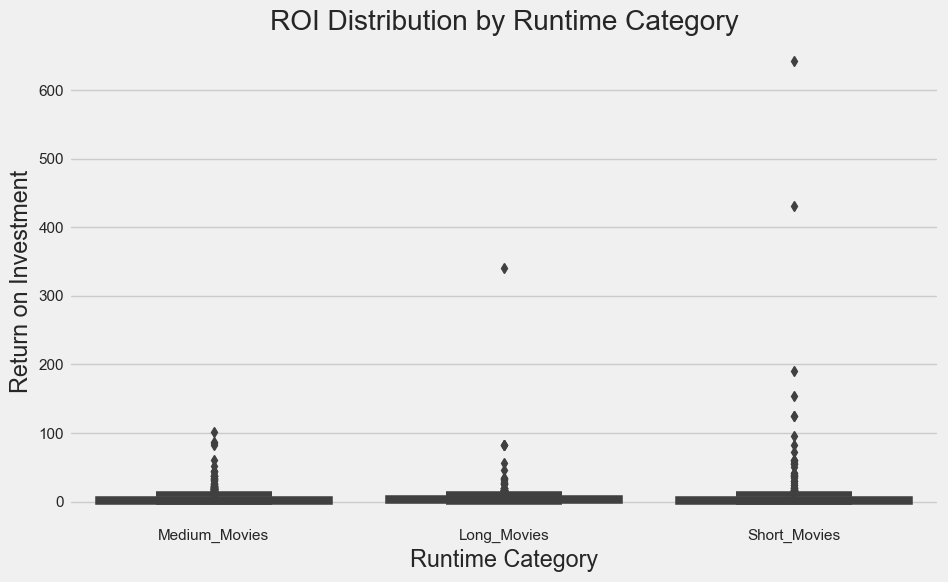

In [118]:
# Bar plot for average ROI by runtime category
plt.figure(figsize=(10, 6))
sns.barplot(x='runtime_category', y='ROI', data=average_roi_by_runtime)
plt.title('Average ROI by Runtime Category')
plt.xlabel('Runtime Category')
plt.ylabel('Average Return on Investment')
plt.show()

# Box plot for ROI distribution by runtime category
plt.figure(figsize=(10, 6))
sns.boxplot(x='runtime_category', y='ROI', data=merged)
plt.title('ROI Distribution by Runtime Category')
plt.xlabel('Runtime Category')
plt.ylabel('Return on Investment')
plt.show()


In [119]:
from scipy import stats

# Perform Kruskal-Wallis H-test
kruskal_result = stats.kruskal(short_roi, medium_roi, long_roi)

print(f'Kruskal-Wallis Result: H={kruskal_result.statistic}, p={kruskal_result.pvalue}')


Kruskal-Wallis Result: H=2.0, p=0.36787944117144245


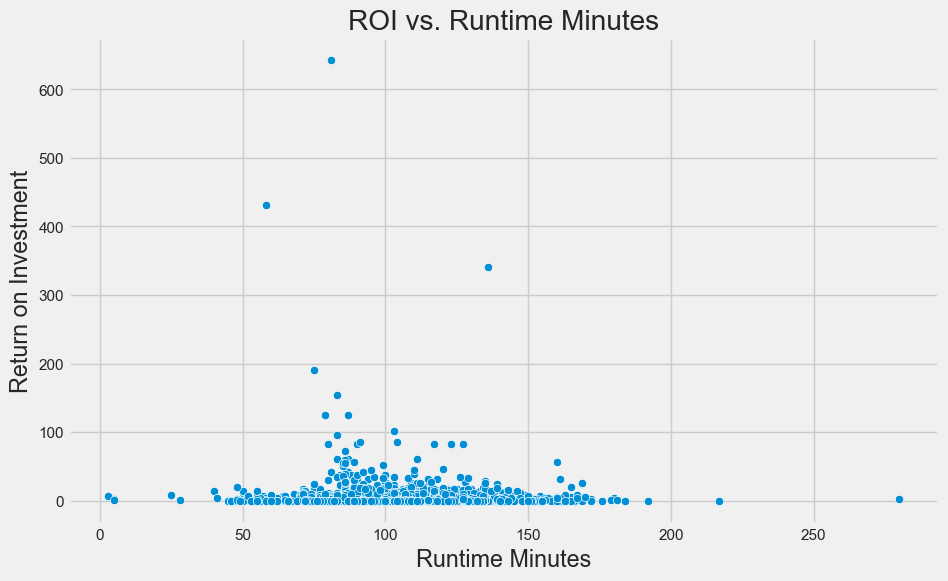

In [120]:
# Visualising the Runtime of movies against ROI
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged['runtime_minutes'], y=merged['ROI'])
plt.title('ROI vs. Runtime Minutes')
plt.xlabel('Runtime Minutes')
plt.ylabel('Return on Investment')
plt.show() 

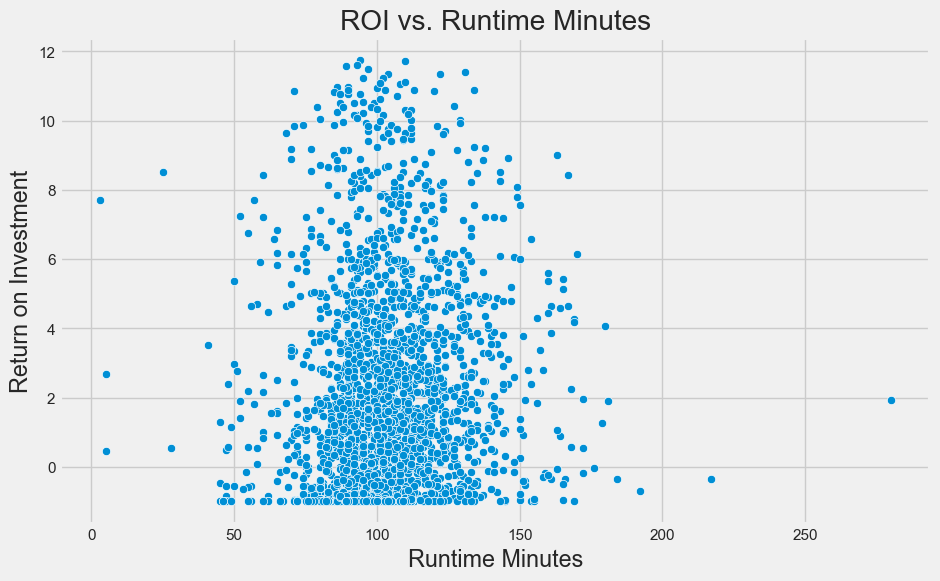

In [121]:
#Showing Correlation of Runtime minutes using filtered data from ROI
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged['runtime_minutes'], y=mergedROI_no_outliers['ROI'])
plt.title('ROI vs. Runtime Minutes')
plt.xlabel('Runtime Minutes')
plt.ylabel('Return on Investment')
plt.show() 

In [122]:
# Filter the dataset for movies with runtime between 90 and 113 minutes (Typical Runtime)
filtered_data = merged[(merged['runtime_minutes'] >= 90) & (merged['runtime_minutes'] <= 113)]


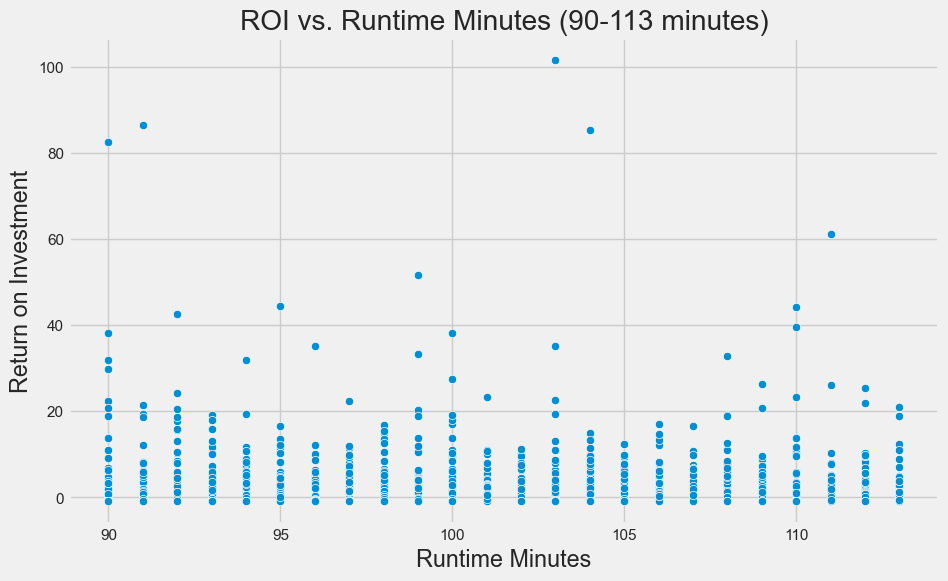

In [123]:
# Visualize the dataset
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x='runtime_minutes', y='ROI')
plt.title('ROI vs. Runtime Minutes (90-113 minutes)')
plt.xlabel('Runtime Minutes')
plt.ylabel('Return on Investment')
plt.show()


In [124]:
# Calculate the correlation coefficient
correlation = filtered_data['runtime_minutes'].corr(filtered_data['ROI'])
print(f'Correlation between Runtime Minutes and ROI (90-113 minutes): {correlation}')

# Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data for regression
X = filtered_data[['runtime_minutes']]
y = filtered_data['ROI']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Correlation between Runtime Minutes and ROI (90-113 minutes): 0.00967859169955726
Mean Squared Error: 93.56159388850658
R^2 Score: -0.004167456103390421


In [125]:
import statsmodels.api as sm

# Add a constant term for the intercept
X_train_const = sm.add_constant(X_train)

# Fit the regression model using statsmodels
model = sm.OLS(y_train, X_train_const).fit()

# Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.004647
Date:                Fri, 26 Jul 2024   Prob (F-statistic):              0.946
Time:                        21:07:23   Log-Likelihood:                -3783.4
No. Observations:                1125   AIC:                             7571.
Df Residuals:                    1123   BIC:                             7581.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.3859      2.992     

## Analysis of Film Profitability by Runtime Category

To determine which films are more profitable based on their runtime categories, we analyzed the Return on Investment (ROI) across different runtime categories: Short Movies, Medium Movies, and Long Movies.

### Data Summary

Here is a summary of the ROI data for each runtime category:

| Runtime Category | ROI       | Runtime (Minutes) |
|------------------|-----------|-------------------|
| Short Movies     | 6.85      | 90                |
| Medium Movies    | 3.31      | 113               |
| Long Movies      | 4.60      | 150               |

### Statistical Analysis

To compare the profitability across these runtime categories, we performed the Kruskal-Wallis H-test, a non-parametric test used to determine if there are statistically significant differences between the medians of three or more independent groups.

#### Kruskal-Wallis Test Results

- **H-statistic**: 2.00
- **p-value**: 0.368

### Interpretation

The Kruskal-Wallis test results show a p-value of 0.368. Since this p-value is greater than the common significance level of 0.05, we do not have sufficient evidence to reject the null hypothesis. This means that there is no statistically significant difference in the profitability (ROI) among the different runtime categories in this dataset.

### Key Findings

#### 1. Correlation Analysis:

- **Correlation Coefficient**: The correlation coefficient between runtime minutes and ROI is **0.0097**.
- **Interpretation**: This indicates a **very weak positive correlation**, suggesting that there is **almost no relationship between runtime minutes and ROI for movies with runtimes between 90 and 113 minutes**.

#### 2. Linear Regression Model:

- **Mean Squared Error (MSE)**: The MSE of the model is **93.56**, indicating the average squared difference between the predicted and actual ROI values.
- **R^2 Score**: The R^2 score is **-0.0042**.
- **Interpretation**: The negative R^2 score suggests that the model does not explain the variance in ROI and performs worse than a horizontal line representing the mean ROI.

#### 3. Regression Coefficients:

- **Intercept (const)**: 3.3859
- **Coefficient for Runtime Minutes**: -0.0020
- **P-Value** for Runtime Minutes: 0.946 (greater than 0.05)
- **Interpretation**: The high p-value indicates that **runtime minutes are not a statistically significant predictor of ROI** within the specified range.

#### 4. F-statistic:

- **F-statistic**: 0.004647
- **Prob (F-statistic)**: 0.946
- **Interpretation**: The F-statistic and its corresponding p-value **confirm that runtime minutes do not significantly explain the variation in ROI**.

## Conclusion

- Based on the analysis, the profitability of films does not significantly differ across short, medium, and long runtime categories given the current data.
- Additionally, the correlation and regression analyses suggest that runtime minutes are not a significant predictor of ROI.


## 3.  Runtime vs Average Rating

## Question :Do viewers Prefer long or short movies? 

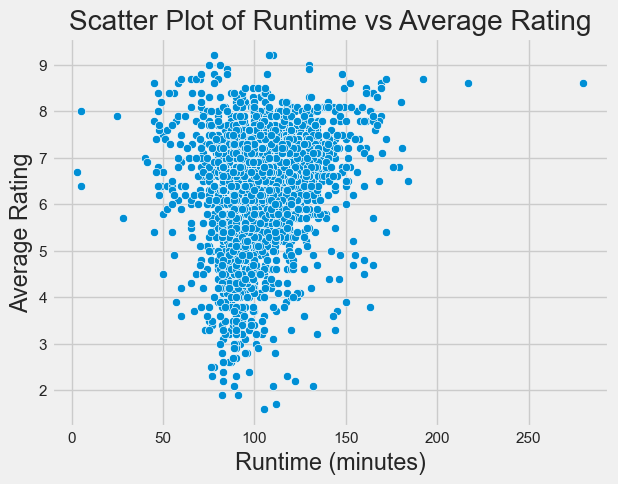

In [126]:
# Create scatter plot
sns.scatterplot(x='runtime_minutes', y='averagerating', data=merged)
plt.title('Scatter Plot of Runtime vs Average Rating')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

Both the runtime and the average rating of a film are continuous. As such, the ideal analyses to be conducted are:
 * Correlation
 * Regression

For this, I have chosen to use a scatter plot and perform Spearman and Pearson tests to identify the strength of the correlation.

In [127]:
from scipy.stats import pearsonr, spearmanr

# Calculate Pearson correlation and p-value
pearson_corr, pearson_p_value = pearsonr(merged['runtime_minutes'], merged['averagerating'])
print(f"Pearson Correlation: {pearson_corr}, P-value: {pearson_p_value}")

# Calculate Spearman correlation and p-value
spearman_corr, spearman_p_value = spearmanr(merged['runtime_minutes'], merged['averagerating'])
print(f"Spearman Correlation: {spearman_corr}, P-value: {spearman_p_value}")

Pearson Correlation: 0.21576583427572257, P-value: 3.110472762052897e-29
Spearman Correlation: 0.2470610302982779, P-value: 4.458671297457196e-38


#### Pearson Correlation
- The **Pearson Correlation Coefficient** :(0.216) indicates a **weak positive linear relationship** between movie runtime and average rating.

 - The **p-value** : (3.11×10−29) is much less than 0.05, indicating that the **correlation is statistically significant**.

#### Spearman Correlation
-  The **Spearman Correlation Coefficient** : (0.247) indicates a **weak positive monotonic relationship** between movie runtime and average rating.

- The **p-value** (4.46x10-38) is much less than 0.05, indicating that the **correlation is statistically significant**.

Both Pearson and Spearman correlations show a weak but statistically significant positive relationship between movie runtime and average rating.

In [128]:
# Calculate average rating for each runtime category
average_rating_by_runtime = merged.groupby('runtime_category')['averagerating'].mean().reset_index()
print(average_rating_by_runtime)


  runtime_category  averagerating
0      Long_Movies       6.710000
1    Medium_Movies       6.118266
2     Short_Movies       5.983564


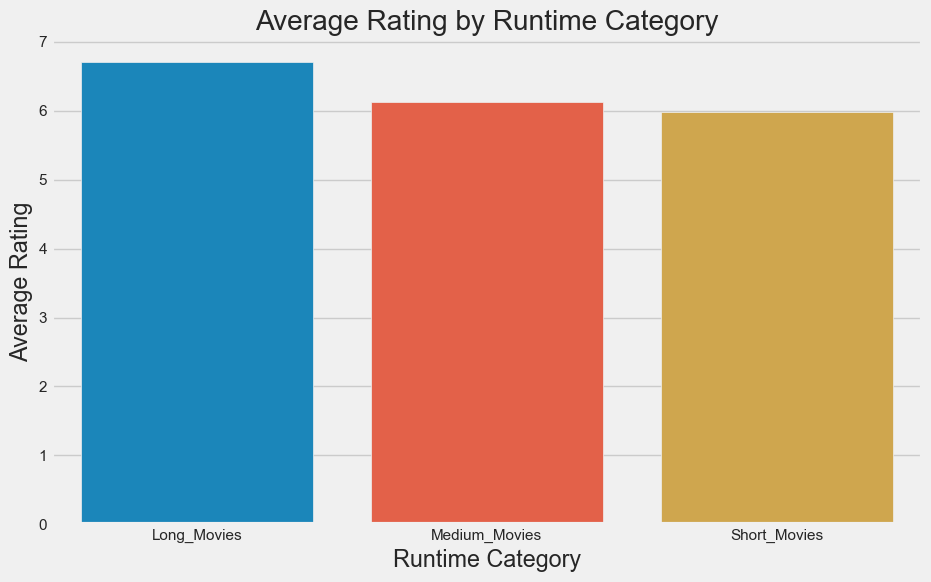

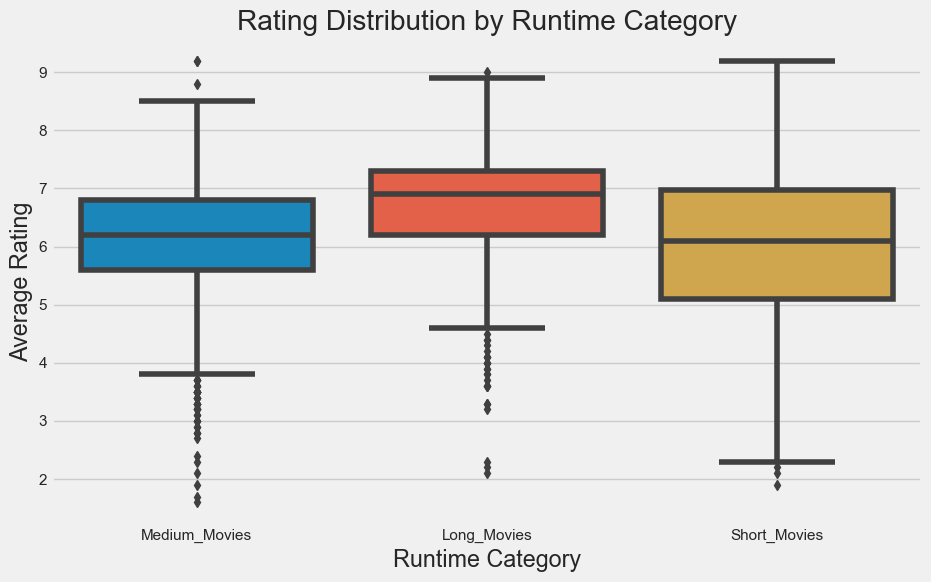

In [129]:
# Bar plot for average rating by runtime category
plt.figure(figsize=(10, 6))
sns.barplot(x='runtime_category', y='averagerating', data=average_rating_by_runtime)
plt.title('Average Rating by Runtime Category')
plt.xlabel('Runtime Category')
plt.ylabel('Average Rating')
plt.show()

# Box plot for rating distribution by runtime category
plt.figure(figsize=(10, 6))
sns.boxplot(x='runtime_category', y='averagerating', data=merged)
plt.title('Rating Distribution by Runtime Category')
plt.xlabel('Runtime Category')
plt.ylabel('Average Rating')
plt.show()


#### Interpretation
- **Viewer Preference**: The descriptive statistics reveal that viewers tend to give **higher ratings to longer movies**. Specifically, movies with runtimes greater than 120 minutes have the highest average rating (6.71), followed by medium-length movies (6.12), and short movies (5.98).
Insights and Recommendations
- **Preference for Longer Movies**: The analysis indicates a preference for longer movies among viewers, as evidenced by the higher average ratings for long movies.
Strategic Focus: Based on these findings, consider focusing on producing longer movies to achieve higher viewer ratings. However, it's crucial to consider other factors.

## 4.  Distribution of Genre  vs  ROI

## Question : Which genres are most profitable?

In [130]:
# Calculate average ROI by genre
avg_ROI_by_genre = mergedROI_no_outliers.groupby('genre_1')['ROI'].mean().sort_values(ascending=False).reset_index()

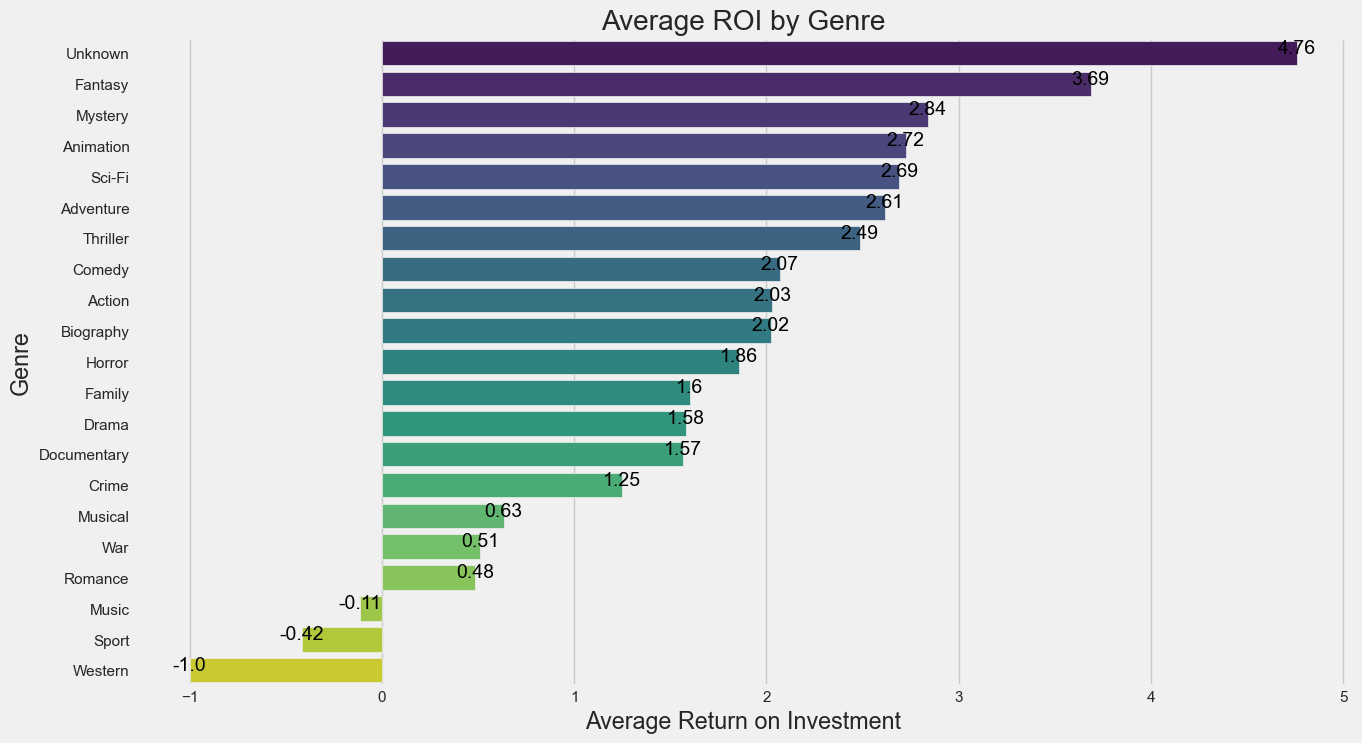

In [131]:
# Bar plot for average ROI by genre
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='ROI', y='genre_1', data=avg_ROI_by_genre, palette='viridis')
plt.title('Average ROI by Genre')
plt.xlabel('Average Return on Investment')
plt.ylabel('Genre')

# Add counts on top of each bar
for index, row in avg_ROI_by_genre.iterrows():
    barplot.text(row.ROI, index, round(row.ROI, 2), color='black', ha="center")

plt.show()

In [132]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform  ANOVA to determmine whether the difference are signficant
model = ols('ROI ~ C(genre_1)', data=mergedROI_no_outliers).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                  sum_sq      df        F    PR(>F)
C(genre_1)    410.206902    20.0  2.36608  0.000579
Residual    21038.433090  2427.0      NaN       NaN


## Analysis of ROI by Genre

To determine which genres are most profitable, we performed an ANOVA test. The results are as follows:

| Source       | Sum of Squares | df   | F-value | p-value  |
|--------------|----------------|------|---------|----------|
| Genre        | 410.21         | 20   | 2.37    | 0.000579 |
| Residual     | 21038.43       | 2427 | NaN     | NaN      |

Based on the ANOVA results, we conclude that **there are significant differences in ROI** across genres (p-value < 0.05).

### Conclusion

- The genres with the highest average ROI are **Fantasy , mystery , animation** with average ROI's of **4.76, 3.69, 2.84** respectively


## 5. Distribution of Genres of Ratings

## Question : Which genres are most popular among viewers?

In [133]:
Primary_genre = merged['genre_1']
Ratings = merged['averagerating']

# Calculate average rating by genre
avg_rating_by_genre = merged.groupby('genre_1')['averagerating'].mean().sort_values(ascending=False).reset_index()

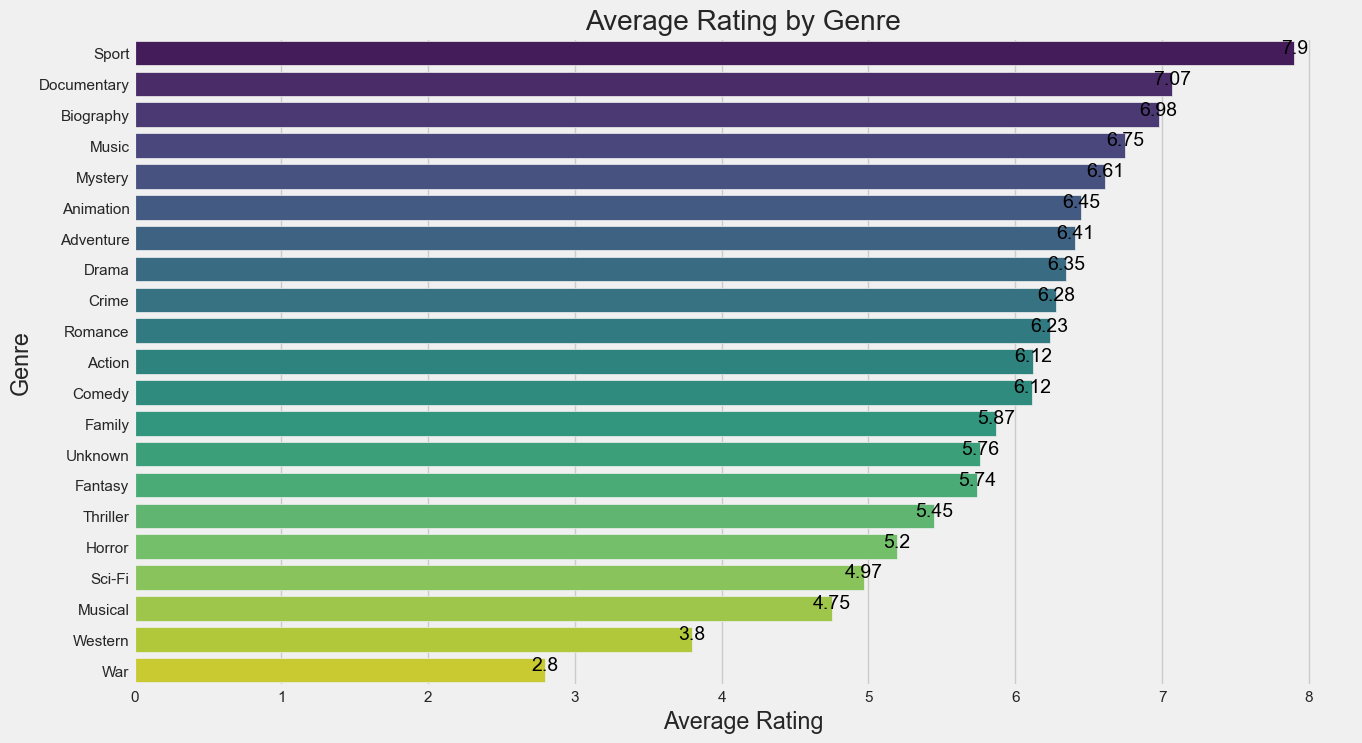

In [134]:
# Plot of a barplot of ROI against genres
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='averagerating', y='genre_1', data=avg_rating_by_genre, palette='viridis')
plt.title('Average Rating by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')

# Add counts on top of each bar
for index, row in avg_rating_by_genre.iterrows():
    barplot.text(row.averagerating, index, round(row.averagerating, 2), color='black', ha="center")

plt.show()

#### Statistical Tests

In [135]:
# Perform ANOVA
model = ols('averagerating ~ C(genre_1)', data=merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq      df          F        PR(>F)
C(genre_1)   472.778945    20.0  19.606034  1.608251e-65
Residual    3163.750356  2624.0        NaN           NaN


## Analysis of Ratings by Genre Summary

### Statistical Analysis

To determine which genres are most popular among viewers, we performed an ANOVA test. The results are as follows:

| Source       | Sum of Squares | df   | F-value | p-value        |
|--------------|----------------|------|---------|----------------|
| Genre        | 472.78         | 20   | 19.61   | 1.61e-65       |
| Residual     | 3163.75        | 2624 | NaN     | NaN            |

Based on the ANOVA results, we conclude that there are significant differences in ratings across genres (p-value < 0.05).

### Conclusion

- The genres with the highest average ratings are **Sport, Documentary, Biography,Music**
- This analysis helps in understanding which genres are most popular among viewers 

# Multivariate Analysis

## Distribution of ROI , runtime and average rating

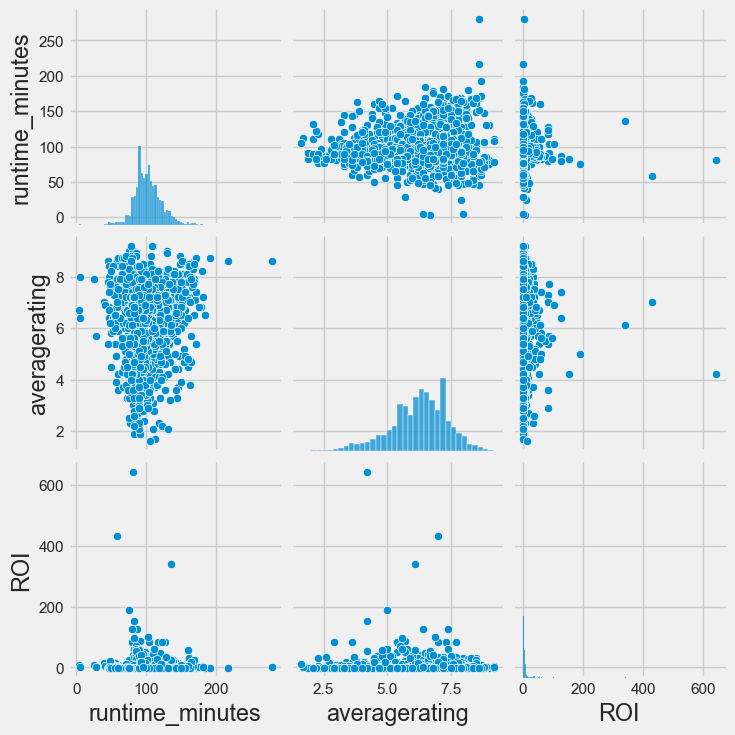

In [136]:
 #plotting of the pair plot
sns.pairplot(merged[['runtime_minutes', 'averagerating', 'ROI']])
plt.show()

### Statistical Multivariate Analysis

In [137]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'data' is your DataFrame and it includes 'roi', 'runtime_minutes', 'average_rating', and 'genre_encoded'

# Prepare the data
X = merged[['runtime_minutes', 'averagerating', ]]  # Independent variables
y = merged['ROI']  # Dependent variable

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.015
Date:                Fri, 26 Jul 2024   Prob (F-statistic):              0.363
Time:                        21:07:30   Log-Likelihood:                -11572.
No. Observations:                2645   AIC:                         2.315e+04
Df Residuals:                    2642   BIC:                         2.317e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.8064      2.506     

### Interpretation
- **R-squared**: The R-squared value is **0.001**, indicating that only 0.1% of the variance in ROI is explained by the model. This suggests that **runtime and average rating are not strong predictors of ROI**.
#### Coefficients:
- **Intercept (const)**: 5.8064, which is the expected ROI when all predictors are zero.
- **Runtime Minutes**: -0.0259, indicating a very weak negative relationship with ROI. However, the p-value (0.165) is greater than 0.05, suggesting this relationship is not statistically significant.
  
- **Average Rating**: 0.2012, indicating a very **weak positive relationship with ROI**. The p-value (0.538) is also greater than 0.05, indicating this relationship is not statistically significant.
- **F-statistic**: The F-statistic is 1.015 with a **p-value of 0.363**, indicating that the **overall model is not statistically significant**.

# CONCLUSSION & SUMMARY


- This project aimed to analyze movie data to provide insights on what types of films are performing best at the box office, helping a new movie studio decide what types of films to create. The analysis utilized data from Box Office Mojo, IMDB, Rotten Tomatoes, TheMovieDB, and The Numbers.

## Key Findings

## Univariate Analysis
1. Average Rating Distribution
- The most common rating is 6.2, with highly rated movies (rating ≥ 9) being rare (1% of the dataset).
  
2. Runtime Distribution
 - The most common runtime is 101 minutes, with the majority of movies having runtimes between 90 and 113 minutes.
   
3. Return on Investment (ROI)
The most common ROI is 1.09, with the majority of films having ROIs between -0.58 and 3.52.

4. Genre Distribution
The top genres are Drama (26.2%), Action (23.8%), and Comedy (19.7%).

5. Production Budgets
The most common budget range is 0 - 50 million dollars, with the highest budget being 425 million dollars (Avatar).

## Bivariate Analysis
1. Film Profitability by Runtime Category
- There is no significant difference in profitability among short, medium, and long movies.
  
2. Ratings by Genre
- The highest average ratings are :( **rating > 6.2**)

| GENRE        | Average_Rating |
|--------------|----------------|
| Sport        | 7.9            | 
| Documentary  | 7.07           |    
| Biography    | 6.98           |
| Music        | 6.75           |
| Mystery      | 6.61           |
| Animation    | 6.45           |        
| Adventure    | 6.41           |


3. Genre by ROI
- The most profitable genres are  :(**ROI > 2.50** )
| GENRE        | Retrun on Inv. |
|--------------|----------------|
| Fantasy      | 4.76           | 
| Mystery      | 3.69           |    
| Aniamtion    | 2.72           |
| Sci-Fi       | 2.69           |
| Adventure    | 2.61           |


## Multivariate Analysis
A multiple linear regression model was used to predict ROI based on runtime, average rating, and genre. The model showed that runtime and average rating are not strong predictors of ROI, with an R-squared value of 0.001.

## Correlation Analysis
- There is a weak positive correlation between vote average and ROI (0.2019).
- There is a weak positive correlation between runtime minutes and ROI (0.0097).

## Linear Regression Models
- Vote average is not a statistically significant predictor of ROI.
- Runtime minutes are not a statistically significant predictor of ROI.
  

# RECOMMENDATIONS

1. Focus on **Profitable & are highly rated genres**. The most profitable & highly_rated genres are:
 - **Mystery**
 - **Animation**
 - **Adventure**

2. **Consider Viewer Preferences**: Longer movies tend to have higher ratings.

3. **Budget Consideration**s: Most successful films have moderate budgets.


This comprehensive analysis provides actionable insights for the new movie studio, guiding them on the types of films to create for better box office performance.

